In [ ]:
import glob
import os
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import math
import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import cartopy.crs as crs
import random

from termcolor import colored
from loadbar import LoadBar

class ais_df_process():
    '''
    This is for a dataset with ports and ids...
    
    '''
    def __init__(self):
        '''
        self.training_df = None
        self.testing_df = None
        self.validation_df = None
        
        self.statistics_training = None
        self.statistics_testing = None
        self.statistics_validation = None
        
        self.training_normalized_df = None
        self.testing_normalized_df = None
        self.validation_normalized_df = None
        
        self.training_df_dynamic = None
        self.testing_df_dynamic = None
        self.validation_df_dynamic = None
        
        self.samples_training = []
        self.samples_validation = []
        self.samples_testing = []

        self.samples_description = None
        self.targets_description = None

        self.targets_training = []
        self.targets_validation = []
        self.targets_testing = []
        
        
        
        self.lookback = 5 #timestamp. Time lookback is = lookback*sampling_frq
        self.lookback_offset = 1 #if starting the count self.lookback_offset steps after first location
        self.dynamic_data_type = None # Normalized or not. infor

        self.sampling_rate = None #minutsglobal x
        
        '''
        self.training_df = None
        self.testing_df = None
        self.validation_df = None
        
        self.statistics_training = None
        self.statistics_testing = None
        self.statistics_validation = None
        
        self.statistics_training_zscore = None
        self.statistics_testing_zscore = None
        self.statistics_validation_zscore = None
        
        self.statistics_training_minmax = None
        self.statistics_testing_minmax = None
        self.statistics_validation_minmax = None
        
        self.training_normalized_df = None
        self.testing_normalized_df = None
        self.validation_normalized_df = None
        
        self.training_df_dynamic = None
        self.testing_df_dynamic = None
        self.validation_df_dynamic = None
        
        self.samples_training = []
        self.samples_validation = []
        self.samples_testing = []

        self.samples_description = None
        self.targets_description = None

        self.targets_training = []
        self.targets_validation = []
        self.targets_testing = []
        
        
        self.feature_index = None #which feature you wanna use..
        self.lookback = 5 #timestamp. Time lookback is = lookback*sampling_frq
        self.lookback_offset = 1 #if starting the count self.lookback_offset steps after first location
        self.dynamic_data_type = None # Normalized or not. infor
        self.target_observations = None
        self.sampling_rate = None #minutsglobal x
        self.verbose = 1
        
        
        self.allowed_stop = None
        self.Ids_time = None
        self.min_messages = None
        self.max_speed = None
        self.min_speed = None
        self.max_cog = None
        self.min_cog = None
        self.lat_min = None
        self.lat_max = None
        self.long_min = None
        self.long_max = None
        
        
        self.std_standardization = None
        self.mean_standardization = None
        self.min_normalization = None
        self.max_normalization = None
            
        
    def load_datasets(self,
                      train,
                      val,
                      test):
        
        
        
        self.training_df = pd.read_pickle(train)
        self.testing_df = pd.read_pickle(test)
        self.validation_df = pd.read_pickle(val)
        
    def remove_errors(self):
        '''
        '''
        
        return None
    def load_datafull(self,
                      df):
        
        try:
            df = pd.read_pickle(df)
            df = df.dropna()
            
        except:
            df = df
            df = df.dropna()
        try:
            if df.long.max()>df.lat.max():
                try:
                    df['lon_temp'] =df['lat']
                    try:
                        df.lat = df.lon.astype(np.float32)
                    except:
                        df.lat = df.long.astype(np.float32)
                    
                    
                    df.insert(2, 'long', df.lon_temp.astype(np.float32))
                    try:
                        del df['lon']
                    except:
                        pass
                
                    try:
                        del df['lon_temp']
                    except:
                        pass
                except:
                    pass
        except:
            if df.lon.max()>df.lat.max():
                try:
                    df['lon_temp'] = df['lat']
                    try:
                        df.lat = df.lon.astype(np.float32)
                    except:
                        df.lat = df.long.astype(np.float32)
                    
                    
                    df.insert(2, 'long', df.lon_temp.astype(np.float32))
                    try:
                        del df['lon']
                    except:
                        pass
                
                    try:
                        del df['lon_temp']
                    except:
                        pass
                except:
                    pass
        
        try:
            df = df.rename(columns={"datatime": "time"})
        except:
            pass
        
        try:
            df = df.rename(columns={"lon": "long"})
        except:
            pass
        
        try:
            df.cog = df.cog.astype(np.float32)
            df.sog = df.sog.astype(np.float32)
        except:
            pass     
    
        try:
            which_mmsi = df.mmsi.unique()
        except:
            which_mmsi = df.MMSI.unique()
            
        random.Random(42).shuffle(which_mmsi)
        
        train_val = which_mmsi[0:int(len(which_mmsi)*0.8)]
        
        test = which_mmsi[int(len(which_mmsi)*0.8):]
        train = train_val[0:int(len(train_val)*0.8)]
        val = train_val[int(len(train_val)*0.8):]
        
        try:
            self.training_df = df[df.mmsi.isin(train)]
            self.testing_df = df[df.mmsi.isin(test)]
            self.validation_df = df[df.mmsi.isin(val)]
        except:
            self.training_df = df[df.MMSI.isin(train)]
            self.testing_df = df[df.MMSI.isin(test)]
            self.validation_df = df[df.MMSI.isin(val)]
            
        del df, which_mmsi, val, test, train
        
    def check_data(self,
                   speed_range=[None,None],
                   cog_range=[None,None],
                   lat_range=[None,None],
                   long_range=[None,None]):
        
        
        self.max_speed = speed_range[1]
        self.min_speed = speed_range[0]
        self.max_cog = cog_range[1]
        self.min_cog = cog_range[0]
        self.lat_min = lat_range[0]
        self.lat_max = lat_range[1]
        self.long_min = long_range[0]
        self.long_max = long_range[1]
        
        
        try:
            self.training_df = self.training_df.rename(columns={"id": "Ids"})
            self.testing_df = self.testing_df.rename(columns={"id": "Ids"})
            self.validation_df = self.validation_df.rename(columns={"id": "Ids"})
        except:
            pass
        
        try:
            self.training_df = self.training_df.drop(['level_0', 'index'], axis=1)
            self.testing_df = self.testing_df.drop(['level_0', 'index'], axis=1)
            self.validation_df = self.validation_df.drop(['level_0', 'index'], axis=1)
        except:
            pass
        
        
        
        try:
            self.training_df['Time'] = self.training_df.time
            self.testing_df['Time'] = self.testing_df.time
            self.validation_df['Time'] = self.validation_df.time
        except:
            pass
        
        try:
            #i mean, the trajectories with the followign ids should be deleted.. Currently, they are not
            #delete_train =(self.training_df.groupby('Ids').cog.count()<10)
            #delete_train = delete_trai[delete_train].index
            
            delete_train = np.array([])
            delete_train = np.append(delete_train,(self.validation_df.groupby('Ids').cog.count()<5)[(self.validation_df.groupby('Ids').cog.count()<5)].index.values)
            delete_train = np.append(delete_train,(self.validation_df.groupby('Ids').sog.max()<0.5)[(self.validation_df.groupby('Ids').sog.max()<0.5)].index.values)
            self.training_df = self.training_df[~self.training_df.Ids.isin(delete_train)]
            
            delete_test =(self.testing_df.groupby('Ids').cog.count()<10)
            delete_test = delete_test[delete_test].index
            self.testing_df = self.testing_df[~self.testing_df.Ids.isin(delete_test)]
            
            delete_val =(self.validation_df.groupby('Ids').cog.count()<10)
            delete_val = delete_val[delete_val].index
            self.validation_df = self.validation_df[~self.validation_df.Ids.isin(delete_val)]
            
            del delete_train, delete_test, delete_val
        except:
            pass

        
        
        
        if self.max_speed!=None:  
            try:
                self.training_df = self.training_df[self.training_df.sog<self.max_speed]
                self.testing_df = self.testing_df[self.testing_df.sog<self.max_speed]
                self.validation_df = self.validation_df[self.validation_df.sog<self.max_speed]
            except Exception as e:
                print('\ncant remove outliers',e)
                
        if self.min_speed!=None:  
            try:
                self.training_df = self.training_df[self.training_df.sog>self.min_speed]
                self.testing_df = self.testing_df[self.testing_df.sog>self.min_speed]
                self.validation_df = self.validation_df[self.validation_df.sog>self.min_speed]
            except Exception as e:
                print('\ncant remove outliers',e)
                
        if self.max_cog!=None:     
            try:
                self.training_df = self.training_df[self.training_df.cog<self.max_cog]
                self.testing_df = self.testing_df[self.testing_df.cog<self.max_cog]
                self.validation_df = self.validation_df[self.validation_df.cog<self.max_cog]
            except Exception as e:
                print('\ncant remove outliers',e)
            
        if self.min_cog!=None:    
            try:
                self.training_df = self.training_df[self.training_df.cog>self.min_cog]
                self.testing_df = self.testing_df[self.testing_df.cog>self.min_cog]
                self.validation_df = self.validation_df[self.validation_df.cog>self.min_cog]
            except Exception as e:
                print('\ncant remove outliers',e)
                
                
        if lat_range[0]!=None:    
            try:
                self.training_df = self.training_df[self.training_df.lat>lat_range[0]]
                self.testing_df = self.testing_df[self.testing_df.lat>lat_range[0]]
                self.validation_df = self.validation_df[self.validation_df.lat>lat_range[0]]
            except Exception as e:
                print('\ncant remove outliers',e)
                
        if lat_range[1]!=None:    
            try:
                self.training_df = self.training_df[self.training_df.lat<lat_range[1]]
                self.testing_df = self.testing_df[self.testing_df.lat<lat_range[1]]
                self.validation_df = self.validation_df[self.validation_df.lat<lat_range[1]]
            except Exception as e:
                print('\ncant remove outliers',e)
                
                
        if long_range[0]!=None:    
            try:
                self.training_df = self.training_df[self.training_df.long>long_range[0]]
                self.testing_df = self.testing_df[self.testing_df.long>long_range[0]]
                self.validation_df = self.validation_df[self.validation_df.long>long_range[0]]
            except Exception as e:
                pass
                
                
            try:
                self.training_df = self.training_df[self.training_df.lon>long_range[0]]
                self.testing_df = self.testing_df[self.testing_df.lon>long_range[0]]
                self.validation_df = self.validation_df[self.validation_df.lon>long_range[0]]
            except Exception as e:
                pass
                
        if long_range[1]!=None:    
            try:
                self.training_df = self.training_df[self.training_df.long<long_range[1]]
                self.testing_df = self.testing_df[self.testing_df.long<long_range[1]]
                self.validation_df = self.validation_df[self.validation_df.long<long_range[1]]
            except Exception as e:
                print('\ncant remove outliers',e)
                
            try:
                self.training_df = self.training_df[self.training_df.lon<long_range[1]]
                self.testing_df = self.testing_df[self.testing_df.lon<long_range[1]]
                self.validation_df = self.validation_df[self.validation_df.lon<long_range[1]]
            except Exception as e:
                pass
            
            
        try:
            self.training_df['Lat'] = self.training_df.lat
            self.testing_df['Lat'] = self.testing_df.lat
            self.validation_df['Lat'] = self.validation_df.lat
        except:
            pass
        
        
                
        
        
    def add_derived_values_dist(self,
                                which=['pct','running']):
        '''
        '''
        if 'distance' in(which):
            try:
                self.training_df = ais_df_process.add_distance(self.training_df)
                self.testing_df = ais_df_process.add_distance(self.testing_df)
                self.validation_df = ais_df_process.add_distance(self.validation_df)
            except:
                pass
            
          
        
        if 'pct' in(which):
            try:
                self.training_df = ais_df_process.add_dist_pct(self.training_df)
                self.testing_df = ais_df_process.add_dist_pct(self.testing_df)
                self.validation_df = ais_df_process.add_dist_pct(self.validation_df)
            except:
                pass
            
        if 'running' in(which):
            try:
                self.training_df = ais_df_process.add_running_distance(self.training_df)
                self.testing_df = ais_df_process.add_running_distance(self.testing_df)
                self.validation_df = ais_df_process.add_running_distance(self.validation_df)
            except:
                pass
            
        
          
        
    def add_derived_values_time(self):   
        
        
        self.training_df = ais_df_process.add_time(self.training_df)
        self.testing_df = ais_df_process.add_time(self.testing_df)
        self.validation_df = ais_df_process.add_time(self.validation_df)
        
           
        self.training_df = ais_df_process.add_time_spent(self.training_df)
        self.testing_df = ais_df_process.add_time_spent(self.testing_df)
        self.validation_df = ais_df_process.add_time_spent(self.validation_df)
        
        self.training_df = ais_df_process.add_total_time_spent(self.training_df)
        self.testing_df = ais_df_process.add_total_time_spent(self.testing_df)
        self.validation_df = ais_df_process.add_total_time_spent(self.validation_df)
        
        
        
    def add_derived_values_bearing(self):   
        
        self.training_df = ais_df_process.add_bearing(self.training_df)
        self.testing_df = ais_df_process.add_bearing(self.testing_df)
        self.validation_df = ais_df_process.add_bearing(self.validation_df)
    def add_derived_values_speed(self):    
        self.training_df = ais_df_process.add_speed(self.training_df)
        self.testing_df = ais_df_process.add_speed(self.testing_df)
        self.validation_df = ais_df_process.add_speed(self.validation_df)
        
    def add_derived_values_delta_coordinated(self):
        self.training_df = ais_df_process.add_delta_coordinates(self.training_df)
        self.testing_df = ais_df_process.add_delta_coordinates(self.testing_df)
        self.validation_df = ais_df_process.add_delta_coordinates(self.validation_df)
        
        
        
        
        
    #def add_derived_values_speed(self):      
        
    def add_resampling(self,Resampling_frq=5):
        global resampling_frq
        #resampling_frq = Resampling_frq
        self.sampling_rate = Resampling_frq
        
        try:
            self.training_df_dynamic = ais_df_process.get_resampling(self.training_df,resampling_frq=Resampling_frq)
            self.testing_df_dynamic = ais_df_process.get_resampling(self.testing_df,resampling_frq=Resampling_frq)
            self.validation_df_dynamic = ais_df_process.get_resampling(self.validation_df,resampling_frq=Resampling_frq)
            #self.dynamic_data_type = 'Not#_normalized'
            #df_dynamic = df_dynamic.reset_index(drop=True)            
        except:
            pass
            #self.training_df_dynamic = ais_df_process.get_resampling(self.training_normalized_df)
            #self.testing_df_dynamic = ais_df_process.get_resampling(self.testing_normalized_df)
            #self.validation_df_dynamic = ais_df_process.get_resampling(self.validation_normalized_df)
            #self.dynamic_data_type = 'Normalized'
            
        try:
            delete_id = []
            for Id in self.training_df_dynamic.Ids.unique():
                if len(self.training_df_dynamic[self.training_df_dynamic.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.training_df_dynamic = self.training_df_dynamic[~self.training_df_dynamic.Ids.isin(delete_id)]
        except:
            pass
            
        try:
            delete_id = []
            for Id in self.testing_df_dynamic.Ids.unique():
                if len(self.testing_df_dynamic[self.testing_df_dynamic.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.testing_df_dynamic = self.testing_df_dynamic[~self.testing_df_dynamic.Ids.isin(delete_id)]
        except:
            pass
            
        try:
            delete_id = []
            for Id in self.validation_df_dynamic.Ids.unique():
                if len(self.validation_df_dynamic[self.validation_df_dynamic.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.validation_df_dynamic = self.validation_df_dynamic[~self.validation_df_dynamic.Ids.isin(delete_id)]
        except:
            pass
        
        
        try:
            self.training_normalized_df = self.training_normalized_df.drop(['index'], axis=1)
            self.validation_normalized_df = self.validation_normalized_df.drop(['index'], axis=1)
            self.testing_normalized_df = self.testing_normalized_df.drop(['index'], axis=1)
        except:
            pass
            
        try:
            self.training_df = self.training_df.drop(['index'], axis=1)
            self.validation_df = self.validation_df.drop(['index'], axis=1)
            self.testing_df = self.testing_df.drop(['index'], axis=1)
        except:
            pass


            
        

    
    #samples = data2.set_index('time').groupby(['id'])['long','lat','sog','cog','Distance_PCT','Distance','time_left'].resample(f'{resampling_time}min',origin='start').mean().pad()
        
    def clean_data(self):
        self.training_df.lat = self.training_df.lat.round(8).astype(np.float32)
        self.training_df.long = self.training_df.long.round(8).astype(np.float32)
        self.training_df.sog = self.training_df.sog.round(2).astype(np.float32)
        self.training_df.cog = self.training_df.cog.round(1).astype(np.float32)
        
        self.testing_df.lat = self.testing_df.lat.round(8).astype(np.float32)
        self.testing_df.long = self.testing_df.long.round(8).astype(np.float32)
        self.testing_df.sog = self.testing_df.sog.round(2).astype(np.float32)
        self.testing_df.cog = self.testing_df.cog.round(1).astype(np.float32)
        
        self.validation_df.lat = self.validation_df.lat.round(8).astype(np.float32)
        self.validation_df.long = self.validation_df.long.round(8).astype(np.float32)
        self.validation_df.sog = self.validation_df.sog.round(2).astype(np.float32)
        self.validation_df.cog = self.validation_df.cog.round(1).astype(np.float32)
        
        
    def get_stats(self):
        '''
        '''
        try:
            self.statistics_training = self.training_df_dynamic.describe()
            self.statistics_testing = self.testing_df_dynamic.describe()
            self.statistics_validation = self.validation_df_dynamic.describe()
        except:
            self.statistics_training = self.training_df.describe()
            self.statistics_testing = self.testing_df.describe()
            self.statistics_validation = self.validation_df.describe()
            if self.verbose>1:
                print('Can not get statistics of dynamic set. Making it from the full set.')
        
        
    def get_sub_sequences(self,
                          allowed_stop=100,
                          min_messages = 120,
                          Ids_time='2016'):
        
        self.allowed_stop = allowed_stop
        self.min_messages = min_messages
        self.Ids_time = Ids_time
        
        try:
            self.training_df = ais_df_process.get_split_trajecotries(self.training_df,
                                                                     allowed_stop=allowed_stop,
                                                                     min_messages = min_messages,
                                                                     time_id=Ids_time)
            self.testing_df = ais_df_process.get_split_trajecotries(self.testing_df,
                                                                     allowed_stop=allowed_stop,
                                                                    min_messages = min_messages,
                                                                     time_id=Ids_time)
            self.validation_df = ais_df_process.get_split_trajecotries(self.validation_df,
                                                                     allowed_stop=allowed_stop,
                                                                       min_messages = min_messages,
                                                                     time_id=Ids_time)
        except Exception as e:
            print('cant split trajectories\n',e)
            pass          
            
        
       
       
    ######################################################################     
    ######### Derived features ########################################### 
    ################################### ################################### 
    
    
    ######################################################################
    ## TIME ### 
    

    
    def time(df):
        try:
            df['time_left']=np.round((df.to_time-df.Time).astype('timedelta64[s]')/60,2)
            df = df.reset_index(drop=True)
        except:
            df['time_left']=np.round((df.Time.iloc[-1]-df.Time).astype('timedelta64[s]')/60,2)
            df = df.reset_index(drop=True)
        return df
    
    
    def add_time(df):
        try:
            df = df.groupby('Ids').apply(ais_df_process.time)
            df = df.reset_index(drop=True)
        except:
            df = df.groupby('mmsi').apply(ais_df_process.time)
            df = df.reset_index(drop=True)
        return df
    
    
    
    
    def time_spent(df):
        try:
            temp = df.Time.diff()
            temp.iloc[0] = pd.Timedelta(np.timedelta64(0, "ms"))
            df['Running_time'] = temp
            df.Running_time =df.Running_time / np.timedelta64(1, 's')
            df = df.reset_index(drop=True)
            del temp
        except:
            temp = df.Time.diff()
            temp.iloc[0] = pd.Timedelta(np.timedelta64(0, "ms"))
            df['Running_time'] = temp
            
            df.Running_time =df.Running_time / np.timedelta64(1, 's')
            df = df.reset_index(drop=True)
            del temp
        return df

    def add_time_spent(df):
        try:
            df = df.groupby('Ids').apply(ais_df_process.time_spent)
            df = df.reset_index(drop=True)
        except:
            df = df.groupby('mmsi').apply(ais_df_process.time_spent)
            df = df.reset_index(drop=True)
        return df
    
    
    
    def total_time_spent(df):
        df['Total_time_spent'] = df['Running_time'].cumsum().astype(np.float32)
        df = df.reset_index(drop=True)
        return df
    
    def add_total_time_spent(df):
        try:
            df = df.groupby('Ids').apply(ais_df_process.total_time_spent)
            df = df.reset_index(drop=True)
        except:
            df = df.groupby('mmsi').apply(ais_df_process.total_time_spent)
            df = df.reset_index(drop=True)
        return df
    
    
    
    
    ######################################################################
    ######################################################################
                                ## DISTANCE ###  
    ######################################################################
    def dist_pct(df):
        try:
            df['Distance_percentage']=(df['Total_distance'] / df['Total_distance'].max()).astype(np.float32)
        except:
            pass
        return df
    def add_dist_pct(df):
        try:
            df = df.groupby('Ids').apply(ais_df_process.dist_pct)
            df = df.reset_index(drop=True)
        except:
            pass
        return df
        
    
    def haversine_distance(df):
        dist = haversine((df.index[0],df.iloc[0]), (df.index[1],df.iloc[1]), unit=Unit.NAUTICAL_MILES)
        return dist
    
    def total_distance(df):
        
        try:
            df = df.set_index('Lat')
            df['Distance2'] = df['long'].rolling(2).apply(ais_df_process.haversine_distance, raw=False)
            df['Total_distance'] = df['Distance2'].cumsum().astype(np.float32)
            df['Total_distance'].iloc[1] = df['Distance2'].iloc[1].astype(np.float32)
            #df=df.iloc[1:,:]
            del df['Distance2']
            df = df.reset_index()
        except:
            pass
        return df

    def add_distance(df):
        try:
            df = df.groupby('Ids').apply(ais_df_process.total_distance)
            df = df.reset_index(drop=True)
        except:
            df = df.groupby('Ids').apply(ais_df_process.total_distance)
            df = df.reset_index(drop=True)
            
            
        try:
            del df['Distance2']
        except:
            pass
        return df
    
    
    def running_distance(df):
        df = df.set_index('Lat')
        df['Running_distance'] = df['long'].rolling(2).apply(ais_df_process.haversine_distance, raw=False).astype(np.float32)
        df=df.iloc[1:,:]
        df = df.reset_index()
        
        return df
    
    def add_running_distance(df):
        try:
            df = df.groupby('Ids').apply(ais_df_process.running_distance)
            df = df.reset_index(drop=True)
        except:
            df = df.groupby('Ids').apply(ais_df_process.running_distance)
            df = df.reset_index(drop=True)
        return df
    
    
    ### Speed ####
    def speed(df):
        #runnin distances (nautilus miles) to meters
        # m/s to knots (by multiplying 1.943844)
        df['speed_calculated'] = ((df.Running_distance*1852)/(df.Running_time )*1.943844).astype(np.float32)
        df['speed_calculated'].iloc[0] = 0
        df = df.reset_index(drop=True)
        return df

    def add_speed(df):
        try:
            df = df.groupby('Ids').apply(ais_df_process.speed)
            df = df.reset_index(drop=True)
        except:
            df = df.groupby('Ids').apply(ais_df_process.speed)
    
        return df
    
    ## bearing ###  
    def calculate_bearing(df):
        pointA = df.index[0],df.iloc[0]
        pointB = df.index[1],df.iloc[1]
        lat1 = math.radians(pointA[0])
        lat2 = math.radians(pointB[0])
        
        diffLong = math.radians(pointB[1] - pointA[1])
        x = math.sin(diffLong) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(diffLong))
        initial_bearing = math.atan2(x, y)
        initial_bearing = math.degrees(initial_bearing)
        compass_bearing = (initial_bearing + 360) % 360
        #print(initial_bearing,compass_bearing)
        return compass_bearing
        
    def bearing(df):
        df = df.set_index('Lat')
        df['bearing_calculated'] = df['long'].rolling(2).apply(ais_df_process.calculate_bearing, raw=False).astype(np.float32)
        df['bearing_calculated'].iloc[0] = df['bearing_calculated'].iloc[1]
        #df = df.reset_index(drop=True)
        df = df.reset_index(drop=True)
        return df
    
    def add_bearing(df):
        df = df.groupby('Ids').apply(ais_df_process.bearing)
        df = df.reset_index(drop=True)
        return df
    
    ######################3
    def co_ordinates(df):
        df['delta_lat'] = df.lat.diff().astype(np.float32)
        df['delta_lat'].iloc[0] = 0
        
        try:
            df['delta_lon'] = df.lon.diff().astype(np.float32)
            df['delta_lon'].iloc[0] = 0
        except:
            df['delta_long'] = df.long.diff().astype(np.float32)
            df['delta_long'].iloc[0] = 0
        else:
            pass
        return df
    
    def add_delta_coordinates(df):
        df = df.groupby('Ids').apply(ais_df_process.co_ordinates)
        df = df.reset_index(drop=True)
        return df
        
    ######################################################################  
    ######################################################################  
    def add_normalize(self,which = 'MinMax'):
        '''
        '''
        assert which.lower() in ['minmax','zscore','max_abs'],'wrong normalization'
        
        try:
            self.training_normalized_df, self.validation_normalized_df , self.testing_normalized_df = ais_df_process.normalize(self.training_df_dynamic,
                                                                                                                               self.validation_df_dynamic,
                                                                                                                               self.testing_df_dynamic,
                                                                                                                               which=which)
            self.dynamic_data_type = 'Normalized and resampled'

        except Exception as e:
            if self.verbose>0:
                print('error in normalising the resampled values.\n',e)
            self.training_normalized_df, self.validation_normalized_df , self.testing_normalized_df = ais_df_process.normalize(self.training_df,
                                                                                                                               self.validation_df,
                                                                                                                               self.testing_df,
                                                                                                                               which=which)
            self.dynamic_data_type = 'Normalized and not resampled'
            
        try:
            self.training_normalized_df = self.training_normalized_df.drop(['index'], axis=1)
            self.validation_normalized_df = self.validation_normalized_df.drop(['index'], axis=1)
            self.testing_normalized_df = self.testing_normalized_df.drop(['index'], axis=1)
        except:
            pass
            
        try:
            self.training_df = self.training_df.drop(['index'], axis=1)
            self.validation_df = self.validation_df.drop(['index'], axis=1)
            self.testing_df = self.testing_df.drop(['index'], axis=1)
        except:
            pass
        
        
        
        try:
            delete_id = []
            for Id in self.training_normalized_df.Ids.unique():
                if len(self.training_normalized_df[self.training_normalized_df.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.training_normalized_df = self.training_normalized_df[~self.training_normalized_df.Ids.isin(delete_id)]
        except:
            pass
          
        try:
            delete_id = []
            for Id in self.validation_normalized_df.Ids.unique():
                if len(self.validation_normalized_df[self.validation_normalized_df.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.validation_normalized_df = self.validation_normalized_df[~self.validation_normalized_df.Ids.isin(delete_id)]
        except:
            pass
        
        try:
            delete_id = []
            for Id in self.testing_normalized_df.Ids.unique():
                if len(self.testing_normalized_df[self.testing_normalized_df.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.testing_normalized_df = self.testing_normalized_df[~self.testing_normalized_df.Ids.isin(delete_id)]
        except:
            pass
        
    def standardize(training_df,
                    validation_df,
                    testing_df,
                    which = 'zscore'):
        '''
        
        '''
        training_standardized_df = training_df.copy()
        testing_standardized_df = testing_df.copy()
        validation_standardized_df = validation_df.copy()
        
        no_standardize = ['Ids','mmsi','time','from_locode','to_locode','combi']
        standardize = training_df.columns[~training_df.columns.isin(no_standardize)]
        
        
        if which.lower()=='zscore':
            for column in training_df[standardize].columns:
                try:
                    training_standardized_df[column] =(training_df[column] -training_df[column].mean()) / training_df[column].std()
                    testing_standardized_df[column] = (testing_df[column] - training_df[column].mean()) / training_df[column].std()
                    validation_standardized_df[column] =(validation_df[column] - training_df[column].mean()) / training_df[column].std()
                except Exception as e:
                    print(e)
                    pass
                
                
        standardization_means= training_df.mean()
        standardization_std  = training_df.std()
        
        return training_standardized_df, validation_standardized_df, testing_standardized_df, standardization_means, standardization_std

    
    def normalize(training_df,
                  validation_df,
                  testing_df,
                  which = 'minMax'):
        '''
        
        '''
        training_normalized_df = training_df.copy()
        testing_normalized_df = testing_df.copy()
        validation_normalized_df = validation_df.copy()
        
        no_normalize = ['Ids','mmsi','time','from_locode','to_locode','combi']
        normalize = training_df.columns[~training_df.columns.isin(no_normalize)]
        
        if which.lower()=='minmax':
            for column in training_df[normalize].columns:
                try:
                    training_normalized_df[column] = (training_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                    testing_normalized_df[column] = (testing_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                    validation_normalized_df[column] = (validation_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                except Exception as e:
                    print(e)
                    pass
        
        if which.lower()=='max_abs':
            for column in training_df[normalize].columns:
                try:
                    training_normalized_df[column] =training_df[column]  / training_df[column].abs().max()
                    testing_normalized_df[column] = testing_df[column]  / training_df[column].abs().max()
                    validation_normalized_df[column] =validation_df[column]  / training_df[column].abs().max()
                except Exception as e:
                    print(e)
                    pass
                
                
        normalization_max= training_df.max()
        normalization_min  = training_df.min()
            
        return training_normalized_df, validation_normalized_df , testing_normalized_df, normalization_min, normalization_max
    
    
    
    def add_std_norm(self,
                     which_normalize:str = 'MinMax',
                     which_standard:str = 'zscore',clean:bool = False):
        '''
        '''
        assert which_normalize in ['minmax','max_abs',None], 'wrong normalization'
        assert which_standard in ['zscore',None], 'wrong standardization'
        
        
        if which_standard!=None:
            try:
                train_std_df, val_std_df, test_std_df,mean, std = ais_df_process.standardize(self.training_df_dynamic,
                                                                                             self.validation_df_dynamic,
                                                                                           self.testing_df_dynamic,
                                                                                           which=which_standard)
                self.dynamic_data_type = 'Resampled, Standardized'
                self.std_standardization = std
                self.mean_standardization = mean
                del mean, std
            except Exception as e:
                print('error in standardising values.\n',e)
            
        if which_normalize!=None and which_standard!=None:
            try:
                train_std_norm_df, val_std_norm_df, test_std_norm_df,mini, maxi = ais_df_process.normalize(train_std_df,
                                                                                                       val_std_df,
                                                                                                       test_std_df,
                                                                                                       which=which_normalize)
                self.dynamic_data_type = 'Resampled, Standardized, Normalized'
                self.min_normalization = mini
                self.max_normalization = maxi
                del maxi, mini
            except Exception as e:
                print('error in normalising the resampled values.\n',e)
                
        
        if which_normalize!=None and which_standard==None:
            try:
                train_norm_df, val_norm_df, test_norm_df,mini, maxi = ais_df_process.normalize(self.training_df_dynamic,
                                                                                                       self.validation_df_dynamic,
                                                                                                       self.testing_df_dynamic,
                                                                                                       which=which_normalize)
                self.dynamic_data_type = 'Resampled, Standardized, Normalized'
                self.min_normalization = mini
                self.max_normalization = maxi
                del maxi, mini
                                                                                               
            except Exception as e:
                print('error in normalising the resampled values.\n',e)
            
            
        
        
        if which_normalize!=None and which_standard!=None:     
            self.training_normalized_df = train_std_norm_df
            self.validation_normalized_df = val_std_norm_df
            self.testing_normalized_df = test_std_norm_df
        
            del test_std_norm_df, train_std_norm_df, val_std_norm_df
            
        elif which_normalize==None and which_standard!=None:
            
            try:
                self.training_normalized_df = train_std_df
                self.validation_normalized_df = val_std_df
                self.testing_normalized_df = test_std_df

                del train_std_df, val_std_df, test_std_df
            except Exception as e:
                print(e)
                
            
        elif which_normalize!=None and which_standard==None:
            
            self.training_normalized_df = train_norm_df
            self.validation_normalized_df = val_norm_df
            self.testing_normalized_df = test_norm_df
        
            del train_norm_df, val_norm_df, test_norm_df
        
        
        
        if clean==True:
            try:
                self.training_normalized_df = self.training_normalized_df.drop(['index'], axis=1)
                self.validation_normalized_df = self.validation_normalized_df.drop(['index'], axis=1)
                self.testing_normalized_df = self.testing_normalized_df.drop(['index'], axis=1)
            except:
                pass
        
            try:
                delete_id = []
                for Id in self.training_normalized_df.Ids.unique():
                    if len(self.training_normalized_df[self.training_normalized_df.Ids==Id])<self.min_messages:
                        delete_id.append(Id)

                self.training_normalized_df = self.training_normalized_df[~self.training_normalized_df.Ids.isin(delete_id)]
            except:
                pass

            try:
                delete_id = []
                for Id in self.validation_normalized_df.Ids.unique():
                    if len(self.validation_normalized_df[self.validation_normalized_df.Ids==Id])<self.min_messages:
                        delete_id.append(Id)

                self.validation_normalized_df = self.validation_normalized_df[~self.validation_normalized_df.Ids.isin(delete_id)]
            except:
                pass

            try:
                delete_id = []
                for Id in self.testing_normalized_df.Ids.unique():
                    if len(self.testing_normalized_df[self.testing_normalized_df.Ids==Id])<self.min_messages:
                        delete_id.append(Id)
                self.testing_normalized_df = self.testing_normalized_df[~self.testing_normalized_df.Ids.isin(delete_id)]
            except:
                pass
        
        
        
            dele = []
            temp = self.testing_normalized_df[self.testing_normalized_df.long>5].Ids.unique().tolist()
            for i in range(len(temp)):
                dele.append(temp[i])

            temp = self.testing_normalized_df[self.testing_normalized_df.lat>5].Ids.unique().tolist()
            for i in range(len(temp)):
                dele.append(temp[i])
            self.testing_normalized_df = self.testing_normalized_df[~self.testing_normalized_df.Ids.isin(dele)]



            dele = []
            temp = self.validation_normalized_df[self.validation_normalized_df.long>5].Ids.unique().tolist()
            for i in range(len(temp)):
                dele.append(temp[i])

            temp = self.validation_normalized_df[self.validation_normalized_df.lat>5].Ids.unique().tolist()
            for i in range(len(temp)):
                dele.append(temp[i])
            self.validation_normalized_df = self.validation_normalized_df[~self.validation_normalized_df.Ids.isin(dele)]

            dele = []
            temp = self.training_normalized_df[self.training_normalized_df.long>5].Ids.unique().tolist()
            for i in range(len(temp)):
                dele.append(temp[i])

            temp = self.training_normalized_df[self.training_normalized_df.lat>5].Ids.unique().tolist()
            for i in range(len(temp)):
                dele.append(temp[i])
            self.training_normalized_df = self.training_normalized_df[~self.training_normalized_df.Ids.isin(dele)]


            try:
                del delete_id
            except:
                pass
    
    def normalize_old1(training_df,validation_df,testing_df,which = 'minMax'):
        '''
        
        '''
        training_normalized_df = training_df.copy()
        testing_normalized_df = testing_df.copy()
        validation_normalized_df = validation_df.copy()
        
        no_normalize = ['Ids','mmsi','time','from_locode','to_locode','combi']
        normalize = training_df.columns[~training_df.columns.isin(no_normalize)]
        if which.lower()=='minmax':
            for column in training_df[normalize].columns:
                try:
                    training_normalized_df[column] = (training_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                    testing_normalized_df[column] = (testing_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                    validation_normalized_df[column] = (validation_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                except:
                    pass
            
            try:
                training_normalized_df.to_lat = (training_df.to_lat - training_df.lat.min()) / (training_df.lat.max() - training_df.lat.min())
                training_normalized_df.to_long = (training_df.to_long - training_df.long.min()) / (training_df.long.max() - training_df.long.min())
            
                testing_normalized_df.to_lat = (testing_df.to_lat - training_df.lat.min()) / (training_df.lat.max() - training_df.lat.min())
                testing_normalized_df.to_long = (testing_df.to_long - training_df.long.min()) / (training_df.long.max() - training_df.long.min())
            
                validation_normalized_df.to_lat = (validation_df.to_lat - training_df.lat.min()) / (training_df.lat.max() - training_df.lat.min())
                validation_normalized_df.to_long = (validation_df.to_long - training_df.long.min()) / (training_df.long.max() - training_df.long.min())
            
                training_normalized_df.from_lat = (training_df.from_lat - training_df.lat.min()) / (training_df.lat.max() - training_df.lat.min())
                training_normalized_df.from_long = (training_df.from_long - training_df.long.min()) / (training_df.long.max() - training_df.long.min())
            
                testing_normalized_df.from_lat = (testing_df.from_lat - training_df.lat.min()) / (training_df.lat.max() - training_df.lat.min())
                testing_normalized_df.from_long = (testing_df.from_long - training_df.long.min()) / (training_df.long.max() - training_df.long.min())
                
                validation_normalized_df.from_lat = (validation_df.from_lat - training_df.lat.min()) / (training_df.lat.max() - training_df.lat.min())
                validation_normalized_df.from_long = (validation_df.from_long - training_df.long.min()) / (training_df.long.max() - training_df.long.min())
            except:
                pass
        
        if which.lower()=='zscore':
            for column in training_df[normalize].columns:
                try:
                    training_normalized_df[column] =(training_df[column] -training_df[column].mean()) / training_df[column].std()
                    testing_normalized_df[column] = (testing_df[column] - training_df[column].mean()) / training_df[column].std()
                    validation_normalized_df[column] =(validation_df[column] - training_df[column].mean()) / training_df[column].std()
                except:
                    pass
                
            #try:    
            #    training_normalized_df.to_lat =(training_df[column] -training_df[column].mean()) / training_df[column].std()
            #    training_normalized_df.to_long =(training_df[column] -training_df[column].mean()) / training_df[column].std()
            # 
            #    testing_normalized_df.to_lat =(training_df[column] -training_df[column].mean()) / training_df[column].std()
            #    testing_normalized_df.to_long =(training_df[column] -training_df[column].mean()) / training_df[column].std()
            # 
            #    validation_normalized_df.to_lat =(training_df[column] -training_df[column].mean()) / training_df[column].std()
            #    validation_normalized_df.to_long =(training_df[column] -training_df[column].mean()) / training_df[column].std()
            #except:
            #    pass
               
        if which.lower()=='max_abs':
            for column in training_df[normalize].columns:
                try:
                    training_normalized_df[column] =training_df[column]  / training_df[column].abs().max()
                    testing_normalized_df[column] = testing_df[column]  / training_df[column].abs().max()
                    validation_normalized_df[column] =validation_df[column]  / training_df[column].abs().max()
                except:
                    pass
            try:    
                training_normalized_df.to_lat =training_df.to_lat / training_df.lat.abs().max()
                training_normalized_df.to_long =training_df.to_long / training_df.long.abs().max()
            
                testing_normalized_df.to_lat =testing_df.to_lat / training_df.lat.abs().max()
                testing_normalized_df.to_long =testing_df.to_long / training_df.long.abs().max()
            
                validation_normalized_df.to_lat =validation_df.to_lat / training_df.lat.abs().max()
                validation_normalized_df.to_long =validation_df.to_long / training_df.long.abs().max()
            except:
                pass
            
        return training_normalized_df, validation_normalized_df , testing_normalized_df
    
    
    
    def normalize_old2(self,which = 'MinMax'):
        '''
        
        '''
        self.training_normalized_df = self.training_df.copy()
        self.testing_normalized_df = self.testing_df.copy()
        self.validation_normalized_df = self.validation_df.copy()
        if which.lower()=='minmax':
            for column in self.training_df[['Ids', 'long', 'lat', 'sog',
                                            'cog', 'Total_distance', 'Distance_percentage',
                                            'Running_distance', 'time_left','Running_time',
                                            'Total_time_spent', 'bearing_calculated', 'speed_calculated',
                                            'delta_lat', 'delta_long']].columns:
                self.training_normalized_df[column] = (self.training_df[column] - self.training_df[column].min()) / (self.training_df[column].max() - self.training_df[column].min())
                self.testing_normalized_df[column] = (self.testing_df[column] - self.training_df[column].min()) / (self.training_df[column].max() - self.training_df[column].min())
                self.validation_normalized_df[column] = (self.validation_df[column] - self.training_df[column].min()) / (self.training_df[column].max() - self.training_df[column].min())
            
            self.training_normalized_df.to_lat = (self.training_df.to_lat - self.training_df.lat.min()) / (self.training_df.lat.max() - self.training_df.lat.min())
            self.training_normalized_df.to_long = (self.training_df.to_long - self.training_df.long.min()) / (self.training_df.long.max() - self.training_df.long.min())
            
            self.testing_normalized_df.to_lat = (self.testing_df.to_lat - self.training_df.lat.min()) / (self.training_df.lat.max() - self.training_df.lat.min())
            self.testing_normalized_df.to_long = (self.testing_df.to_long - self.training_df.long.min()) / (self.training_df.long.max() - self.training_df.long.min())
            
            self.validation_normalized_df.to_lat = (self.validation_df.to_lat - self.training_df.lat.min()) / (self.training_df.lat.max() - self.training_df.lat.min())
            self.validation_normalized_df.to_long = (self.validation_df.to_long - self.training_df.long.min()) / (self.training_df.long.max() - self.training_df.long.min())
            
            self.training_normalized_df.from_lat = (self.training_df.from_lat - self.training_df.lat.min()) / (self.training_df.lat.max() - self.training_df.lat.min())
            self.training_normalized_df.from_long = (self.training_df.from_long - self.training_df.long.min()) / (self.training_df.long.max() - self.training_df.long.min())
            
            self.testing_normalized_df.from_lat = (self.testing_df.from_lat - self.training_df.lat.min()) / (self.training_df.lat.max() - self.training_df.lat.min())
            self.testing_normalized_df.from_long = (self.testing_df.from_long - self.training_df.long.min()) / (self.training_df.long.max() - self.training_df.long.min())
            
            self.validation_normalized_df.from_lat = (self.validation_df.from_lat - self.training_df.lat.min()) / (self.training_df.lat.max() - self.training_df.lat.min())
            self.validation_normalized_df.from_long = (self.validation_df.from_long - self.training_df.long.min()) / (self.training_df.long.max() - self.training_df.long.min())
        
        if which.lower()=='zscore':
            for column in self.training_df[['long','lat','cog','sog']].columns:
                self.training_normalized_df[column] =(self.training_df[column] - self.training_df[column].mean()) / self.training_df[column].std()
                self.testing_normalized_df[column] = (self.testing_df[column] - self.training_df[column].mean()) / self.training_df[column].std()
                self.validation_normalized_df[column] =(self.validation_df[column] - self.training_df[column].mean()) / self.training_df[column].std()
               
        if which.lower()=='max_abs':
            for column in self.training_df[['long','lat','cog','sog']].columns:
                self.training_normalized_df[column] =self.training_df[column]  / self.training_df[column].abs().max()
                self.testing_normalized_df[column] = self.testing_df[column]  / self.training_df[column].abs().max()
                self.validation_normalized_df[column] =self.validation_df[column]  / self.training_df[column].abs().max()
                
            self.training_normalized_df.to_lat =self.training_df.to_lat / self.training_df.lat.abs().max()
            self.training_normalized_df.to_long =self.training_df.to_long / self.training_df.long.abs().max()
            
            self.testing_normalized_df.to_lat =self.testing_df.to_lat / self.training_df.lat.abs().max()
            self.testing_normalized_df.to_long =self.testing_df.to_long / self.training_df.long.abs().max()
            
            self.validation_normalized_df.to_lat =self.validation_df.to_lat / self.training_df.lat.abs().max()
            self.validation_normalized_df.to_long =self.validation_df.to_long / self.training_df.long.abs().max()

            
    def resampling(df,resampling_frq=5):
        '''
        First, we generate the underlying data grid by using mean(). 
        This generates the grid with NaNs as values. Afterwards, we fill the NaNs with interpolated values by calling the interpolate() method on the read value column
        '''
        df.index = df.time
        
        try:
            try:
                df = df.resample(f'{resampling_frq}min').mean().interpolate(method='cubicspline')
                
            except:
                try:
                    df = df.resample(f'{resampling_frq}min').mean().interpolate(method='spline', order=3)
                except:
                    df = df.resample(f'{resampling_frq}min').mean().interpolate(method='spline', order=3, s=0.)
                    
                    #print('error in finding sampling frq. 5 min is used.')
                    pass
                pass
        except Exception as e:
            print(f'Error in resampling id: {df.Ids.iloc[0]}: {e}')
            pass


        return df
    
    def get_resampling(df,resampling_frq):
        try:
            df = df.groupby('Ids').apply(ais_df_process.resampling,resampling_frq=resampling_frq)
            df = df.reset_index(drop=True)
        except:
            no_normalize = ['from_locode','to_locode','combi']
            df = df.columns[~df.columns.isin(no_normalize)]
            #df = df[['time','Ids','long','lat','cog','sog']]
            df = df.groupby('Ids').apply(ais_df_process.resampling,resampling_frq=resampling_frq)
            df = df.reset_index(drop=True)
            
        
        #df_dynamic = df_dynamic.reset_index()
        try:
            df = df.drop(['index'], axis=1)
        except:
            pass
        try:
            df = df.drop(['index'], axis=1)
            df = df.drop(['index'], axis=1)
        except:
            pass

        return df
    
    
        
    
    

    
    def datasets_training(df):
        for rows in range(lookback_offset,df.shape[0]-lookback-target_observations+1):
            samples_training.append(df.iloc[rows:rows+lookback,:].to_numpy())
            targets_training.append(df.iloc[rows+lookback:rows+lookback+target_observations,:].to_numpy())
        return None
    
    def datasets_validation(df):
        for rows in range(lookback_offset,df.shape[0]-lookback-target_observations+1):
            samples_validation.append(df.iloc[rows:rows+lookback,:].to_numpy())
            targets_validation.append(df.iloc[rows+lookback:rows+lookback+target_observations,:].to_numpy())
        return None
    
    def datasets_testing(df):
        for rows in range(lookback_offset,df.shape[0]-lookback-target_observations+1):
            samples_testing.append(df.iloc[rows:rows+lookback,:].to_numpy())
            targets_testing.append(df.iloc[rows+lookback:rows+lookback+target_observations,:].to_numpy())
        return None
    
    
    def add_datasets(df_train,df_val,df_test):
        try:
            df_train.groupby('Ids').apply(ais_df_process.datasets_training)
            df_train.reset_index(drop=True)
        except:
            df_train.groupby('id').apply(ais_df_process.datasets_training)
            df_train.reset_index(drop=True)
        
        try:
            df_val.groupby('Ids').apply(ais_df_process.datasets_validation)
            df_val.reset_index(drop=True)
        except:
            df_val.groupby('id').apply(ais_df_process.datasets_validation)
            df_val.reset_index(drop=True)
        
        try:
            df_test.groupby('Ids').apply(ais_df_process.datasets_testing)
            df_test.reset_index(drop=True)
        except:
            df_test.groupby('id').apply(ais_df_process.datasets_testing)
            df_test.reset_index(drop=True)
            
        return None
    
    def get_split_trajecotries(df,
                               allowed_stop=100,
                               min_messages = 120,
                               time_id='2016'):
        '''
    
        '''
        
        try:
            df_temp = df.groupby('mmsi').apply(ais_df_process.split_trajectory,allowed_stop=allowed_stop,time_id=time_id)
            df_temp = df_temp.reset_index(drop=True)
        except:
            df_temp = df.groupby('Ids').apply(ais_df_process.split_trajectory,allowed_stop=allowed_stop,time_id=time_id)
            df_temp = df_temp.reset_index(drop=True)
        
        
        
        try:
            delete_id = []
            for Id in df_temp.Ids.unique():
                if len(df_temp[df_temp.Ids==Id])<min_messages:
                    delete_id.append(Id)
                
            df_temp = df_temp[~df_temp.Ids.isin(delete_id)] 
        except:
            pass
            
        return df_temp
    
    def split_trajectory(df,allowed_stop=100,time_id = '2016'):
        '''
        '''
        #df = df_input.copy()
        df = df.reset_index(drop=True)
        df_combined = pd.DataFrame()
    
        allowed_stop = allowed_stop*60 #sek to min.
        try:
            position_split = df.query(f'elapsed > {allowed_stop} or elapsed < 0').index.values.tolist()
        except Exception as e:
            position_split = df.query(f'Running_time > {allowed_stop} or Running_time < 0').index.values.tolist()
            

        try:
            if len(position_split)>0:
                position_split.insert(0,0)
                position_split.insert(len(position_split),len(df))
                for split in range(len(position_split)-1):
                    df_temp = df.iloc[position_split[split]:position_split[split+1],:]
                    df_temp['Ids'] = f'{df.mmsi.iloc[0]}{time_id}{split+1}'
                    try:
                        df_temp.elapsed.iloc[0] = 0
                    except:
                        pass
                    df_combined = df_combined.append(df_temp)       
            else:
                df_combined = df
                df_combined['Ids'] = f'{df.mmsi.iloc[0]}{time_id}{1}'
                
        except Exception as e:
            print('error in split_trajectory: ',e)
            pass
    
        df_combined.Ids = df_combined.Ids.astype(int)
        df_combined = df_combined.reset_index(drop=True)
        del df
        return df_combined
                    
    
    
    def get_datasets(self,
                     Lookback_offset,
                     Target_observations,
                     Lookback=5):
        global lookback_offset, lookback, samples_training, targets_training, samples_validation, targets_validation, samples_testing, targets_testing, target_observations
        try:
            lookback_offset = Lookback_offset
            lookback = Lookback
            target_observations = Target_observations
            self.lookback_offset = lookback_offset
            self.lookback = lookback
            self.target_observations = target_observations
        except:
            lookback_offset = self.lookback_offset 
            lookback = self.lookback 
            target_observations = self.target_observations 
            
            
        
        
 
        
        samples_training = []
        targets_training = []
        
        samples_validation = []
        targets_validation= []
        
        samples_testing = []
        targets_testing = []
        
        
        try:
            ais_df_process.add_datasets(self.training_normalized_df,
                                    self.validation_normalized_df,
                                    self.testing_normalized_df)
            
            self.samples_description = self.training_normalized_df.columns
            self.targets_description = self.training_normalized_df.columns
        
        except:
            if self.verbose>0:
                print('error in making dataset from normalized values. making them from dynamic')
            ais_df_process.add_datasets(self.training_df_dynamic,
                                    self.validation_df_dynamic,
                                    self.testing_df_dynamic)
            self.samples_description = self.training_df_dynamic.columns
            self.targets_description = self.training_df_dynamic.columns
        


        
        self.samples_training = np.array(samples_training)
        self.targets_training = np.array(targets_training)
        self.samples_validation = np.array(samples_validation)
        self.targets_validation = np.array(targets_validation)
        self.samples_testing = np.array(samples_testing)
        self.targets_testing = np.array(targets_testing)
        del samples_training, targets_training, targets_testing, samples_testing, targets_validation, samples_validation
        
        return None
    
    def get_info(self):
        '''
        '''
        
        info_data = {'Paramter':  ['samples_shape', 
                                   'targets_shape',
                                   'samples_description',
                                   'features_used',
                                   'lookback',
                                   'lookback_offset',
                                   'number_target_observations',
                                   'sampling_rate'],
                     'Value': [self.samples_training.shape, 
                               self.targets_training.shape,
                               self.samples_description,
                               self.feature_index,
                               self.lookback,
                               self.lookback_offset,
                               self.target_observations,
                               self.sampling_rate]
                    }

        df = pd.DataFrame (info_data, columns = ['Paramter','Value'])
        

        

    
    def get_index(self,parms = ['lat',
                       'long',
                       'sog',
                       'cog',
                       'Total_distance',
                       'Running_Distance',
                       'delta_lat',
                       'delta_long']
                 ):
        features = self.samples_description.isin(parms)
        features = pd.Series(features)
        features = features[features].index
        self.feature_index = features
    
        return features
    
    
    def plot_tracks(df):
        
        mrc = ccrs.Mercator()
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

        ax.stock_img()
        ax.gridlines(draw_labels=True)
        try:
            ax.scatter(df.long.to_numpy(),df.lat.to_numpy(),c='red', s=10)
        except:
            ax.scatter(df.lon.to_numpy(),df.lat.to_numpy(),c='red', s=10)
        ax.coastlines()
        try:
            ax.set_extent([ df.long.min()-1, df.long.max()+1,df.lat.min()-1, df.lat.max()+1])
        except:
            ax.set_extent([ df.lon.min()-1, df.lon.max()+1,df.lat.min()-1, df.lat.max()+1])
        plt.show()

        
        
        
    def plot(self):
        (self.training_df.speed_calculated-self.training_df.sog).plot()
        (self.training_df.bearing_calculated-self.training_df.cog).plot()
        
        (self.training_df.bearing_calculated).plot()
        (self.training_df.cog).plot()
        
                

            
        
def save_ais_df(df,filename='ais'):
    '''
    
    '''
    df.reset_index().to_feather(f'{filename}.feather')
    df.reset_index().to_pickle(f"{filename}.pkl")
    
    return None   




# Prediction of maritime trajectory data using an Attention-based Bidirectional LSTM Network

#### Contact:
- Kristian Aalling Soerensen kaaso@space.dtu.dk
- Henning Heiselberg hh@space.dtu.du

## Introduction <a class="anchor" id="zero-bullet"></a>

This Notebook is a detailed description of the Methodology described in [Prediction of maritime trajectory data using an Attention-based Bidirectional LSTM Network](#fiasrst-bullet)(linket kommer naar den er udgivet). It utilizes the costume modules ``` ais_operations ``` and ```models```. The ``` ais_operations ```contains the ```ais_df_process``` class, used to load, pre-process and process the data including the data filtering, resampling and normalization as described in [Prediction of maritime trajectory data using an Attention-based Bidirectional LSTM Network](#fiasrst-bullet). 

The ```models``` module contains both the ```article_model``` and the ```use_model``` classes. The ```article_model``` class is used to initialize, check and make the model. It will automatically compile the model whereafter it can be trained using the class. The ```use_model``` class can be used to make predictions for full datasets, but also individual trajectories. It can furhter be used to analyse the gradients etc. I.e. parts of "Explaniable AI".

The notebook contains "only" the methodology from the [Prediction of maritime trajectory data using an Attention-based Bidirectional LSTM Network](#fiasrst-bullet) article and will start with the dataset, followed by the model and using the model, as seen in [Content](#first-bullet). For more information, and theory see [Prediction of maritime trajectory data using an Attention-based Bidirectional LSTM Network](#fiasrst-bullet). 


The modules are all made for a specific project and is not 'idiot proof'. We are therefore sorry if some bugs occur. Still, you're free to use it as you see fit.. 

## Content <a class="anchor" id="first-bullet"></a>

* #### [Introduction](#zero-bullet)
* #### [Content](#first-bullet)
* #### [Initialize](#second-bullet)
* #### [Data](#third-bullet)
    * ##### [Types of data](#third1-bullet)
    * ##### [Creating dataset](#third2-bullet)
    * ##### [Analysing dataset](#third3-bullet)
    * ##### [Training data](#third4-bullet)
* #### [Model](#forth-bullet)
    * ##### [Choosing features](#forth1-bullet)
    * ##### [Building model](#forth2-bullet)
    * ##### [Seeing model](#forth3-bullet)
    * ##### [Training model](#forth4-bullet)
    
* #### [Testing model](#fifth-bullet)
    * ##### [Testing loss](#fifth1-bullet)
    * ##### [Quatitative evaluation: Metrics](#fifth2-bullet)
    * ##### [Qualitative evaluation: Predictions](#fifth3-bullet)
    * ##### [Explainable AI: Gradients](#fifth4-bullet)
    * ##### [to come](#fifth5-bullet)

    
        

In [ ]:
    def standardize(training_df,
                    validation_df,
                    testing_df,
                    which = 'zscore'):
        '''
        
        '''
        training_standardized_df = training_df.copy()
        testing_standardized_df = testing_df.copy()
        validation_standardized_df = validation_df.copy()
        
        no_standardize = ['Ids','mmsi','time','from_locode','to_locode','combi']
        standardize = training_df.columns[~training_df.columns.isin(no_standardize)]
        
        
        if which.lower()=='zscore':
            for column in training_df[standardize].columns:
                try:
                    training_standardized_df[column] =(training_df[column] -training_df[column].mean()) / training_df[column].std()
                    testing_standardized_df[column] = (testing_df[column] - training_df[column].mean()) / training_df[column].std()
                    validation_standardized_df[column] =(validation_df[column] - training_df[column].mean()) / training_df[column].std()
                except Exception as e:
                    print(e)
                    pass
                
                
        standardization_means= training_df.mean()
        standardization_std  = training_df.std()
        
        return training_standardized_df, validation_standardized_df, testing_standardized_df, standardization_means, standardization_std

    
    def normalize(training_df:,
                  validation_df,
                  testing_df,
                  which = 'minMax'):
        '''
        
        '''
        training_normalized_df = training_df.copy()
        testing_normalized_df = testing_df.copy()
        validation_normalized_df = validation_df.copy()
        
        no_normalize = ['Ids','mmsi','time','from_locode','to_locode','combi']
        normalize = training_df.columns[~training_df.columns.isin(no_normalize)]
        
        if which.lower()=='minmax':
            for column in training_df[normalize].columns:
                try:
                    training_normalized_df[column] = (training_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                    testing_normalized_df[column] = (testing_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                    validation_normalized_df[column] = (validation_df[column] - training_df[column].min()) / (training_df[column].max() - training_df[column].min())
                except Exception as e:
                    print(e)
                    pass
        
        if which.lower()=='max_abs':
            for column in training_df[normalize].columns:
                try:
                    training_normalized_df[column] =training_df[column]  / training_df[column].abs().max()
                    testing_normalized_df[column] = testing_df[column]  / training_df[column].abs().max()
                    validation_normalized_df[column] =validation_df[column]  / training_df[column].abs().max()
                except Exception as e:
                    print(e)
                    pass
                
                
        normalization_max= training_df.max()
        normalization_min  = training_df.min()
            
        return training_normalized_df, validation_normalized_df , testing_normalized_df
    
    
    
    def add_std_norm(self,
                     which_normalize:str = 'MinMax',
                     which_standard:str = 'zscore'):
        '''
        '''
        assert which_normalize.lower() in ['minmax','max_abs'], 'wrong normalization'
        assert which_standard.lower() in ['zscore'], 'wrong standardization'
        
        try:
            train_std_df, val_std_df, test_std_df,mean, std = ais_df_process.standardize(self.training_df_dynamic,
                                                                                       self.validation_df_dynamic,
                                                                                       self.testing_df_dynamic,
                                                                                       which=which_standard)
            train_std_norm_df, val_std_norm_df, test_std_norm_df,mini, maxi = ais_df_process.normalize(self.training_df_dynamic,
                                                                                                       self.validation_df_dynamic,
                                                                                                       self.testing_df_dynamic,
                                                                                                       which=which_normalize)
            self.dynamic_data_type = 'Resampled, Standardized, Normalized'
        except Exception as e:
            print('error in normalising the resampled values.\n',e)
            
            
        self.std_standardization = std
        self.mean_standardization = mean
        self.min_normalization = mini
        self.max_normalization = maxi
            
        self.training_normalized_df = train_std_norm_df
        self.validation_normalized_df = val_std_norm_df
        self.testing_normalized_df = test_std_norm_df
        
        del test_std_norm_df, train_std_norm_df, val_std_norm_df, std, mean, mini, maxi
        
        try:
            self.training_normalized_df = self.training_normalized_df.drop(['index'], axis=1)
            self.validation_normalized_df = self.validation_normalized_df.drop(['index'], axis=1)
            self.testing_normalized_df = self.testing_normalized_df.drop(['index'], axis=1)
        except:
            pass
        
        try:
            delete_id = []
            for Id in self.training_normalized_df.Ids.unique():
                if len(self.training_normalized_df[self.training_normalized_df.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.training_normalized_df = self.training_normalized_df[~self.training_normalized_df.Ids.isin(delete_id)]
        except:
            pass
          
        try:
            delete_id = []
            for Id in self.validation_normalized_df.Ids.unique():
                if len(self.validation_normalized_df[self.validation_normalized_df.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
                    
            self.validation_normalized_df = self.validation_normalized_df[~self.validation_normalized_df.Ids.isin(delete_id)]
        except:
            pass
        
        try:
            delete_id = []
            for Id in self.testing_normalized_df.Ids.unique():
                if len(self.testing_normalized_df[self.testing_normalized_df.Ids==Id])<self.min_messages:
                    delete_id.append(Id)
            self.testing_normalized_df = self.testing_normalized_df[~self.testing_normalized_df.Ids.isin(delete_id)]
        except:
            pass
        
        
        try:
            del delete_id
        except:
            pass

## Initialize <a class="anchor" id="second-bullet"></a>

The later models will be trained on a GPU on a High Power Computer(HPC) cluster. The HPC server has 4x Tesla V100 32Gb GPUs. It is therefore nessesary to initialize a GPU that is available. This can be seen using ```nvidia-smi```.

In [2]:
!nvidia-smi

Wed Oct 20 11:07:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32C    P0    61W / 300W |   1354MiB / 32510MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]='2'

Importing home-made modules;
* ```ais_operations```: is a module cotaining several classes to work with AIS data. The ```ais_df_process``` class is used to create a dataset as described the article.
* ```models```: contains the models, and utility functions for the models.
    * ```use_model``` class can be used to analyse the trained model including making predictions, plotting predictions, for explainable AIS (gradients) etc.
    * ```article_model```: create model
    *```model``` contains maaaaany different arcitectures we have tried out for predictions...


In [5]:
#import sys
#sys.path.append('../../phd')
#from modules.ais_operations import ais_df_process
#from modules.models import article_model, use_model
#import modules.models as models

Details and information abouse the module can be seen with 
```python
?ais_df_process
```

## Data <a class="anchor" id="third-bullet"></a>

[Back to table of content](#first-bullet)

The data is preparred using the ``` ais_df_process ``` module. The input for the module is a dataframe, saved in .pickle or .feather format. The moduel can use both a full dataframe (as acquired straight from the Gatehouse Databse), or dataframes already divided into training, testing and validation sets.



### Types of data <a class="anchor" id="third1-bullet"></a>
[Back to table of content](#first-bullet)

Two types of data can be used; 
- Dynamic AIS data 
- Static Ship data. 

The Dynamic AIS data is taken directly from e.g. Gatehouse Maritime's servers and contains MMSI, lat, long, sog, cog. The Static Ship data data is found using a developed web-crawler in a module called ```trawler```. The web-crawler is not covered in this notebook. Instead, the dataframe containing the information is used. The Static ship data contains MMSI, length, width, name etc.

The static, website data should be downloaded using the ```trawler``` module and can then be loaded as
```python
import pandas as pd
stat_voy = pd.read_pickle('../data/stat_ship_2021-08-25.pkl')
```
I min nuvaerende model bruges ikke statisk data.. Saa det fjernes

### Creating dataset <a class="anchor" id="third2-bullet"></a>
[Back to table of content](#first-bullet)

The data will be preparred as described in the Artickle. First, data are loaded. The data are commercial and will not be made pucblic. As described in the Article, cargo ship AIS data are loaded from the summer months on 2016-2019. They are combined to a single dataframe that will be processed.

In [4]:
import pandas as pd
#Cargo AIS data from the region show in the Article for different months.
df =  pd.read_pickle('data/data_speciale/df_70_N_Norway_2016-06-01_2016-09-01.pkl') 
df2 =  pd.read_pickle('data/data_speciale/df_70_N_Norway_2017-06-01_2017-09-01.pkl')
df3 =  pd.read_pickle('data/data_speciale/df_70_N_Norway_2018-06-01_2018-09-01.pkl')
df4 =  pd.read_pickle('data/data_speciale/df_70_N_Norway_2019-06-01_2019-09-01.pkl')
#combining the AIS data from the different months.
df_combined = pd.concat([df,df2,df3,df4])
#df_combined = pd.concat([df3])
#del df3
del df,df2,df3,df4

The data is processed using the ```ais_df_process``` class. The data is loaded using the ```load_datafull()``` function .The ```check_data()``` is making an initial filtering of the data to reduce the data amount as soon as possible. This is also usefull when specific datasets are of interest. Here, we filter away messages outside of our region of interest. Furhtermore, we remove outliers with a sog larger than 35 kn. 

We then add calculated derived values. We furhtermore divide the trajectories into sub-trajectories, as descibed in the article, with an allowed stop time of 25, and a minimim amount of messages of 100. We are therefore removing 'poor' data when training the model. For later predictions, it is not needed to define a ```min_messages```, as long as there are samples equivalent to the defined ```Lookback```.


We then resample the data and normalize it. Lastly, we make a training, testing and validation set for the Deep Learning model using the ```get_datasets``` function. 

In [5]:
%%time
test = ais_df_process() #init class
test.load_datafull(df_combined) #the combined data is loaded
test.check_data(speed_range=[None,35],
                cog_range=[None,360.1],
                lat_range=[56,65],
                long_range=[3,9.5]) #checking data and filter it.
test.add_derived_values_time() #adding time, running time etc. This is used to make sub-sequences.
test.get_sub_sequences(allowed_stop=25,
                       min_messages = 100,
                       Ids_time='6789') #using running time to get sub-sequences from allowed stop time and min messages
test.check_data(speed_range=[0.1,35],
                cog_range=[None,None],
                lat_range=[None,None],
                long_range=[None,None]) #cheking the sub-sequences.

/tmp/ipykernel_10016/4061762979.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon_temp'] = df['lat']
/zhome/6e/0/109509/miniconda3/envs/kgp/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


CPU times: user 1h 16min 33s, sys: 58.2 s, total: 1h 17min 32s
Wall time: 1h 17min 43s


In [6]:
test.add_derived_values_dist(which=['pct','running']) #adding derived values, distance, running distance etc.
#test.add_derived_values_bearing() #bearing calculated
#test.add_derived_values_speed() # speed calculated
#test.add_derived_values_delta_coordinated() #change of latitude and longitude
test.add_resampling(Resampling_frq=5) #resampling interpolation in minuts.
test.clean_data() # rounding etc. as described in article.
test.get_stats() #getting training statistics.

/zhome/6e/0/109509/miniconda3/envs/kgp/lib/python3.8/site-packages/scipy/interpolate/_cubic.py:673: LinAlgWarning: Ill-conditioned matrix (rcond=1.00863e-16): result may not be accurate.
  s = solve(A, b, overwrite_a=True, overwrite_b=True,


In [7]:
test.add_std_norm(which_normalize = 'minmax',
                  which_standard = 'zscore') #normalize. zscore, minmax, abs are possible.

In [30]:
test.training_normalized_df.lat.max(),test.training_normalized_df.lat.min(),test.training_normalized_df.lat.mean(),test.training_normalized_df.lat.std(),test.training_normalized_df.long.max(),test.training_normalized_df.long.min(),test.training_normalized_df.long.mean(),test.training_normalized_df.long.std()

(1.0,
 0.0,
 0.38904277796067777,
 0.005415640855056686,
 1.0,
 0.0,
 0.5987419352321056,
 0.0045410438244418636)

In [27]:
test.get_datasets(Lookback=20,
                  Lookback_offset = 1,
                     Target_observations = 10) #creating training- testing- and validation samples and targets using lookback and look ahead.

The entire class can now be saved for later use, using e.g. pickle

In [10]:
#import pickle
#filehandler = open("class_20162019_as25_mm_100_r5_zscore_minmax_L30_To_1_20oct.obj","wb")
#pickle.dump(test,filehandler)
#filehandler.close()

In [28]:
import pickle
filehandler = open("data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct.obj","wb")
pickle.dump(test,filehandler)
filehandler.close()

In [29]:
np.save('data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/samples_training.npy', test.samples_training)
np.save('data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/samples_testing.npy', test.samples_testing)
np.save('data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/samples_validation.npy', test.samples_validation)

np.save('data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/targets_training.npy', test.targets_training)
np.save('data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/targets_validation.npy', test.targets_validation)
np.save('data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/targets_testing.npy', test.targets_testing)
np.save('data/class_20162019_as25_mm_100_r5_zscore_minmax_L20_To_10_20oct/samples_description.npy',test.samples_description.to_numpy())

A class can then be loaded as:
```python
file = open("c_20162019_as25_mm_100_r5_zscore_L20_To_1.obj",'rb')
test = pickle.load(file)
file.close()
```

Considering the data are commercial, the class object will not be provided


In [4]:
#import pickle
#file = open("c_20162019_as25_mm_100_r5_zscore_L20_To_1.obj",'rb')
#test = pickle.load(file)
#file.close()

### Analysing dataset <a class="anchor" id="third3-bullet"></a>
[Back to table of content](#first-bullet)

It is always important to check the dataset. Not only to look for outliers, but also to check that everything is as it should be before applying the data to a deep learning model etc.. As they say "shit in, shit out". Here, we are only doing a brief, qualitativly analysis as poc. 

We can look at the coordinates of the data. First, we want to see if the training, validation and testing data in fact resembles each other. (here "just" by looking at simple feature, but a more in-depth analysis should be made, as I have done elsewhere)

#### Coordinates

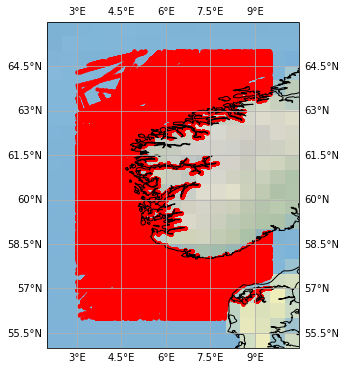

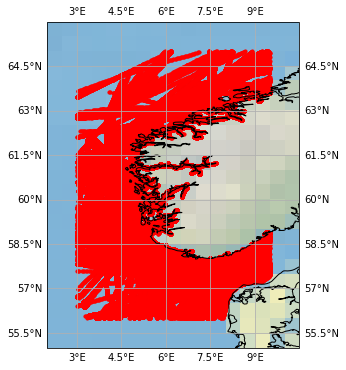

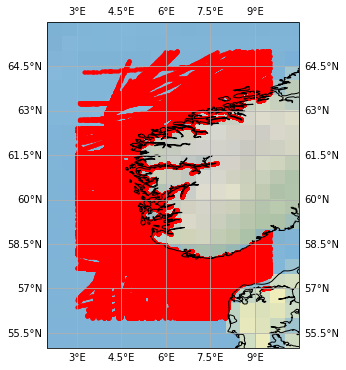

In [12]:
ais_df_process.plot_tracks(test.training_df)
ais_df_process.plot_tracks(test.validation_df)
ais_df_process.plot_tracks(test.testing_df)

We can now check if the standardization/normalization in fact performed as we want it to

In [21]:
test.samples_training[0,0:2,:].T

array([[4.37700624e-01, 4.37732782e-01],
       [2.05477000e+08, 2.05477000e+08],
       [2.67466932e-01, 2.67497997e-01],
       [4.37810240e-01, 4.37842404e-01],
       [8.45275322e-01, 8.45275125e-01],
       [2.06694431e-01, 2.06694497e-01],
       [1.53706441e-01, 1.53669876e-01],
       [3.95010387e-01, 3.95018110e-01],
       [4.80382439e-01, 4.80407066e-01],
       [2.05477001e+13, 2.05477001e+13],
       [8.29733740e-01, 8.29807887e-01],
       [9.13926547e-01, 9.13938487e-01],
       [4.48673799e-02, 4.49333449e-02],
       [4.86526554e-01, 4.86735179e-01]])

In [22]:

long = (test.samples_training[:,:,2].reshape((-1, 1))*(test.max_normalization.long-test.min_normalization.long))+test.min_normalization.long
lat = test.samples_training[:,:,3].reshape((-1, 1))*(test.max_normalization.lat-test.min_normalization.lat)+test.min_normalization.lat



long = long*test.std_standardization.long+test.mean_standardization.long
lat = lat*test.std_standardization.lat+test.mean_standardization.lat

In [27]:
long.max

<function ndarray.max>

ValueError: Failed to determine the required bounds in projection coordinates. Check that the values provided are within the valid range (x_limits=[-180.0, 180.0], y_limits=[-90.0, 90.0]).

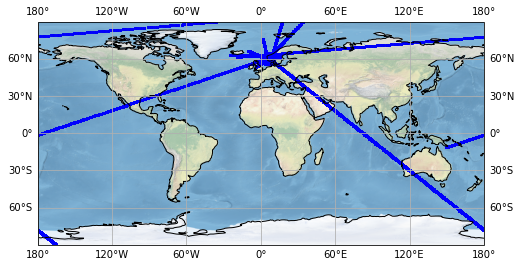

In [24]:
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import math
import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import cartopy.crs as crs
import random

long = (test.samples_training[:,:,2].reshape((-1, 1))*(test.max_normalization.long-test.min_normalization.long))+test.min_normalization.long
lat = test.samples_training[:,:,3].reshape((-1, 1))*(test.max_normalization.lat-test.min_normalization.lat)+test.min_normalization.lat



long = long*test.std_standardization.long+test.mean_standardization.long
lat = lat*test.std_standardization.lat+test.mean_standardization.lat


'''


long = test.samples_testing[:,:,2].reshape((-1, 1))*test.statistics_training.long['std']+test.statistics_training.long['mean']
lat = test.samples_testing[:,:,3].reshape((-1, 1))*test.statistics_training.lat['std']+test.statistics_training.lat['mean']


long = (test.samples_testing[:,:,1].reshape((-1, 1))*(test.statistics_training.long['max']-test.statistics_training.long['min']))+test.statistics_training.long['min']
lat = test.samples_testing[:,:,2].reshape((-1, 1))*(test.statistics_training.lat['max']-test.statistics_training.lat['min'])+test.statistics_training.lat['min']
'''

mrc = ccrs.Mercator()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.stock_img()
ax.gridlines(draw_labels=True)
ax.scatter(long,lat,c='blue', s=1)

ax.coastlines()
ax.set_extent([ long.min()-1, long.max()+1,lat.min()-1, lat.max()+1])

plt.show()


By comparing the pre-and post normlised data, we can see it is the same. Nice

delete_speed = []
for i in test.training_df.Ids.unique():
    dele = test.training_df[test.training_df.Ids==i]
    if ((dele.sog<0.5).any()):
        delete_speed.append(i)
        
Ids_dropout = []
for i in test.training_df.Ids.unique():
    dele = test.training_df[test.training_df.Ids==i]
    if (((dele.Running_time/(60*60))>5).any()):
        Ids_dropout.append(i)
        
        


Ids_dropout_split = []
for i in Ids_dropout:
    dele = test.training_df[test.training_df.Ids==i]
    if (((dele.Running_time/(60*60))>5).any()):
        Ids_dropout.append(i)

test.training_df[test.training_df.Ids==12950].Running_time


temp = ((test.training_df[test.training_df.Ids==52019].Running_time)/(60*60)>2)
temp[temp],



testing['Ids_ex'] = pd.Series(np.zeros((len(testing.mmsi),)))



delete_speed = []
for i in testing.Ids.unique():
    dele = testing[testing.Ids==i]
    if ((dele.sog<0.5).any()):
        delete_speed.append(i)
        
Ids_dropout = []
for i in testing.Ids.unique():
    dele = testing[testing.Ids==i]
    if (((dele.Running_time/(60*60))>5).any()):
        Ids_dropout.append(i)
        

Ids_dropout_split = []
for i in Ids_dropout:
    dele = testing[testing.Ids==i]
    if (((dele.Running_time/(60*60))>5).any()):
        Ids_dropout.append(i)

test.training_df[test.training_df.Ids==12950].Running_time

###  Training data <a class="anchor" id="third4-bullet"></a>
[Back to table of content](#first-bullet)

From the ```get_datasets``` function, we made the datasets. Let us check the shapes to ensure everything is in order. 

In [5]:
test.targets_training.shape,test.samples_training.shape,test.targets_testing.shape,test.samples_testing.shape,test.samples_validation.shape,test.targets_validation.shape

((2982322, 1, 13),
 (2982322, 20, 13),
 (1035751, 1, 13),
 (1035751, 20, 13),
 (892662, 20, 13),
 (892662, 1, 13))

We can furhter check if the values infact are normalized.

In [61]:
for i in range(len(test.samples_training[0,0,:])):
    print(f"{i} {test.samples_description[i]} :\nmax: {test.samples_training[:,:,i].max()}, mean: {test.samples_training[:,:,i].mean()}, std: {test.samples_training[:,:,i].std()}")

0 mmsi :
max: 257836000.0, mean: 244658913.14064774, std: 11472445.61257119
1 long :
max: 0.9976183176040649, mean: 0.48540686653374376, std: 0.2167943982068025
2 lat :
max: 0.9991629719734192, mean: 0.4563203441250865, std: 0.22676259459855086
3 sog :
max: 1.0, mean: 0.3531163275750894, std: 0.272236571028481
4 cog :
max: 1.0, mean: 0.5238769675224065, std: 0.14593747422651213
5 time_left :
max: 0.9961514114389861, mean: 0.4263947199267115, std: 0.2558200944740592
6 Running_time :
max: 1.0, mean: 0.16154450677263232, std: 0.10166565180457564
7 Total_time_spent :
max: 0.996293306350708, mean: 0.43588829657439376, std: 0.2590063330803898
8 Ids :
max: 25783600061.0, mean: 24465891375.2238, std: 1147244561.1685996
9 Running_distance :
max: 1.0, mean: 0.07144101223938189, std: 0.09355473053593538
10 bearing_calculated :
max: 1.0, mean: 0.5572918386873688, std: 0.1636850473514701
11 speed_calculated :
max: 1.0, mean: 0.3931675570417098, std: 0.25594960616893947
12 delta_lat :
max: 1.0, mean

## Model <a class="anchor" id="forth-bullet"></a>

[Back to table of content](#first-bullet)

In the [Data](#third-bullet) section, we made our dataset. Here, we will made a model an train it on the dataset. 
- In [Choosing feature](#forth1-bullet), we choose which features we want to use; In the [Data](#third-bullet) section, we saw how we added several derived features to our dataset. Often, this helps training. In [Choosing feature](#forth1-bullet), we are using the ```get_index``` function to tell out model which features we want in our model. Some derived features are good, some less so. For instance, the derived sog was mainly added to the dataset to illustrate the differences. We will not be used this to train our model.
- In [Building the model](#forth2-bullet), we will be building the mode. Here, sevaral options exists; In this notebook, the ```model_external() ```  model is used. This allows one to add an external model.
    * ##### In [Defining our own model](#forth2a-bullet), we are building a model using the Keras libirary
    * ##### In [Loading old model](#forth2b-bullet), we can load a trained model. This can either be trained continously with the same data, be used for transfer learning, or simply be used to make predictions, e.g. using the ```use_model()``` module.
    * ##### In [Initializing Class](#forth2c-bullet), we are initializing the model class. Here, the model can either be a pre-defined model from the class, e.g. ```model_blstm()``` or it can be an external model (as made in [Defining our own model](#forth2a-bullet)). It can also be the loaded model in [Loading old model](#forth2b-bullet).
- In [Seeing the model](#forth3-bullet), we are seeing a summary of the model. We can furhter see all the paramters in the model, e.g the optimizer etc.
- In [Training the model](#forth4-bullet), we are training the mode. The loss function and metrics are dependant on the model used.


#### Choosing features <a class="anchor" id="forth1-bullet"></a>

In deep learning, the choice of features is important. And emerically, it can be seen that giving the model derived features explicitly will help training. We can therefore choose which features to use. (only use features that are scalled, i.e. not Ids and MMSI). The possible features are given by:
```python
model_features = test.get_index(parms = ['long',
                                         'lat',
                                         'sog',
                                         'cog',
                                         'Total_distance',
                                         'Running_distance',
                                         'Running_time',
                                         'Total_time_spent',
                                         'bearing_calculated',
                                         'speed_calculated',
                                         'delta_lat',
                                         'delta_long'])
```

For this model, we chose the following features.

In [203]:
model_features = test.get_index(parms = ['long',
                                         'lat',
                                         'sog',
                                         'cog'])
input_size = test.samples_training[:,:,model_features].shape[1:]
output_size = test.targets_training[:,:,model_features].shape[1:]

We can now see the shape of our inputs and outputs.

In [210]:
print(input_size)
print(output_size)

(20, 4)
(1, 4)


### Building the model <a class="anchor" id="forth2-bullet"></a>
[Back to table of content](#first-bullet)

The model is buidt using the ```article_model``` module. The following models can be initiated using the module(more available in the developed module):
```python
mod.model_ablstm() #bidirectional lstm with attention (can chose either soft or self attention with carying parms)
mod.model_blstm()  # a birectional lstm
mod.model_ablstm_sim() #bidirectional lstm with attention with hardcoded values. 
mod.model_encoderdecoder(combied_FN_depth:list = [64,64]) # Encoder Decoder blstm structure.
mod.model_cnn(conv_layers = [656,56,456]) # Implemented 1CNN model...
mod.model_thesis() #an old model, as used in my master thesis
mod.model_external(model)
...
```






Furhtermore, we can choose training values; The model will now run for 2000 epochs, or untill a stagnation in loss occurs. 

In [205]:
epochs = 2000
batch_size = 400
cycle_length = test.samples_training[:,:,model_features].shape[0]/epochs # for Cosine annealing, see article.
steps_pr_epoch = int(test.samples_training[:,0,0].shape[0]/batch_size) 

#### Defining our own model <a class="anchor" id="forth2a-bullet"></a>
[Back to table of content](#first-bullet)

Here, we are developing a Mixture Density Network model.

In [206]:
import tensorflow as tf
import mdn
import numpy as np
import tensorflow_probability as tfp
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM,Dense, Bidirectional, Dropout, concatenate, Concatenate, Attention, BatchNormalization, Input, Flatten,Average
from tensorflow.keras.regularizers import l2
import keras.backend as K
import datetime, os
assert '0.12' in tfp.__version__, tfp.__version__ #ensure compatability between tf, tfp and np..
assert '2.4' in tf.__version__, tf.__version__
assert '1.19' in np.__version__, np.__version__


encoder_inputs = Input(shape=(input_size),name='encoder_input')
N_mixers = 11
Dropout_val = 0.1
x = Bidirectional(LSTM(456, 
                       kernel_initializer = tf.keras.initializers.GlorotNormal(),
                       kernel_regularizer=tf.keras.regularizers.l1(0.001),
                       activity_regularizer=tf.keras.regularizers.l2(0.001),
                       return_sequences=True))(encoder_inputs)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(x)
#x = Dense(50, activation='relu')(decoder_inputs_attention)
x = Dropout(Dropout_val)(x)
#
x = Bidirectional(LSTM(456, 
                       kernel_initializer = tf.keras.initializers.GlorotNormal(),
                       kernel_regularizer=tf.keras.regularizers.l1(0.001),
                       activity_regularizer=tf.keras.regularizers.l2(0.001),
                       return_sequences=True))(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(x)
#x = Dense(50, activation='relu')(decoder_inputs_attention)
x = Dropout(Dropout_val)(x)
y = Bidirectional(LSTM(256,
                       kernel_initializer = tf.keras.initializers.GlorotNormal(),
                       kernel_regularizer=tf.keras.regularizers.l1(0.001),
                       activity_regularizer=tf.keras.regularizers.l2(0.001), 
                       return_sequences=False))(x)
y = tf.keras.layers.LeakyReLU(alpha=0.1)(y)
y = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(y)
y = Dropout(Dropout_val)(y)

z = Bidirectional(LSTM(456,
                       kernel_initializer = tf.keras.initializers.GlorotNormal(),
                       kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                       activity_regularizer=tf.keras.regularizers.l2(0.0001), 
                       return_sequences=True))(x)
z = tf.keras.layers.LeakyReLU(alpha=0.1)(z)
z = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(z)
z = Dropout(Dropout_val)(z)
z = Bidirectional(LSTM(256,
                       kernel_initializer = tf.keras.initializers.GlorotNormal(),
                       kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                       activity_regularizer=tf.keras.regularizers.l2(0.0001),
                       return_sequences=False))(z)
z = tf.keras.layers.LeakyReLU(alpha=0.1)(z)
z = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(z)
z = Dropout(Dropout_val)(z)
#attn_out = tf.keras.layers.Attention()([y, z])
#attn_out = Dropout(0)(attn_out)
pred = Average()([z,y])
pred = mdn.MDN(input_size[1], N_mixers)(pred)
name=f"BLSTM_MDN_{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
model = Model(inputs=encoder_inputs, outputs=pred,name=name)

#### Loading old model to continue training or to use <a class="anchor" id="forth2b-bullet"></a>
[Back to table of content](#first-bullet)

We can now load a model. The model can then continiue training, or be used for predicting. It can also be used by others. The model can be loaded using the GPU strategy as:
```python
#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy().scope()
gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])
except RuntimeError as e:
    print(e)
strategy = tf.device(f"/GPU:0")
```
Whereafter the model is loaded

```python
with strategy:
    N_MIXES = 3
    modellen = keras.models.load_model('test_20210917-2026/best_model_test_20210917-2026.h5', custom_objects={'MDN': mdn.MDN,'mdn_loss_func': mdn.get_mixture_loss_func(1, N_MIXES)})
```


Other model:
```python 
modellen = keras.models.load_model('AIS_forcast_20210906-1804/best_model_AIS_forcast_20210906-1804.h5', custom_objects={'loss_function':
Haversine_loss(6356.752),'Haversine_distance':Haversine(6356.752),
'RMSE_distance':rmse_coordinates(),'sog_rmse':diff_sog,'cog_rmse':diff_cog,'distance_rmse':diff_dist,
'lat_rmae':diff_lat,'long_rmse':diff_long,'lr':get_lr_metric})
```

Here, ```custom_objects==...``` are costum layers and functions not available in Keras. These are implemented using Tensorflow and must be inputted to the model.

#### Initializing Class <a class="anchor" id="forth2c-bullet"></a>

Now, using either the "old" model, loaded from disk, or a new defined model, we can use the ```article_model``` class to furhter use the model.

```python
mod = article_model(attention_type='self',
                        encoder_stack_hidden_neurons=[128,128,128,128],
                        FC_neurons = FCs,
                        inputsize=input_size,
                        output_size = output_size,
                        init_lr = 0.00001,
                        self_attention_heads=4,
                        global_dropout=0.4,
                        FC_activation = 'selu',
                        optimizer = 'cosine')
```

In [207]:
N_mixers = 11
Dropout_val = 0.2

import tensorflow as tf
import keras.backend as K
from tensorflow import keras
import mdn

#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy().scope()
gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])
except RuntimeError as e:
    print(e)
strategy = tf.device(f"/GPU:0")

with strategy:
    N_MIXES = 11
    modellen = keras.models.load_model('BLSTM_MDN_20210927-1756/best_model_BLSTM_MDN_20210927-1756.h5', custom_objects={'MDN': mdn.MDN,'mdn_loss_func': mdn.get_mixture_loss_func(1, N_MIXES),'lr':models.get_lr_metric})

```python
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
import mdn

#strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy().scope()
gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])
except RuntimeError as e:
    print(e)
strategy = tf.device(f"/GPU:0")

with strategy:
    N_MIXES = 3
    modellen = keras.models.load_model('BLSTM_MDN_20210922-1056/best_model_BLSTM_MDN_20210922-1056.h5', custom_objects={'MDN': mdn.MDN,'mdn_loss_func': mdn.get_mixture_loss_func(1, N_MIXES)})
``` 

In [11]:
import pandas as pd
te = pd.read_pickle('BLSTM_MDN_20210927-1756/history_newest_epoch_BLSTM_MDN_20210927-1756.pkl')
te.tail(2)

,loss,lr,val_loss,val_lr
13,-13.057213,0.000063,-14.977649,0.000062
14,-13.058844,0.000062,-14.974193,0.000062


In [11]:
te.lr.iloc[-1]

6.226805999176577e-05

In [216]:
histor = []
BLSTM_list = []
for FCs in [[16]]: #if we wanna initialize several models with varying parms for e.g. comparison..
    mod = article_model(inputsize=input_size,
                        output_size = output_size,
                        init_lr = 0.0005,
                        optimizer = 'cosine') #init class
    mod.check_req() 
    mod.prepare_HPC()
    mod.model_external_mdn(model,11) #loading the model.
    mod.model_compiler() #compiling model
    mod.get_callbacks(steps_per_epoch=steps_pr_epoch,
                      wd_norm=0.004,
                      eta_min=0.00000001,
                      eta_max=1,
                      eta_decay=0.7,
                      cycle_length=150,
                      cycle_mult_factor=1) #parms are used for cosine annealing. See article.
    mod.load_data(X_train=test.samples_training.squeeze()[:,:,model_features],
                  Y_train=test.targets_training.squeeze()[:,model_features],
                  X_val=test.samples_validation.squeeze()[:,:,model_features],
                  Y_val=test.targets_validation.squeeze()[:,model_features],
                  X_test=test.samples_testing.squeeze()[:,:,model_features],
                  Y_test =test.targets_testing.squeeze()[:,model_features]) #loading the data into model.

Self_attention_heads is set to 1 by user. Soft-attention is used, and no heads will be used by the model.
Virtual devices cannot be modified after being initialized
mdn in model


### Seeing the model <a class="anchor" id="forth3-bullet"></a>
[Back to table of content](#first-bullet)

We can now look at out model:

In [217]:
mod.model.summary()

Model: "BLSTM_MDN_20210929-1241"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 20, 4)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 912)      1681728     encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 20, 912)      0           bidirectional[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 912)      3648        leaky_re_lu[0][0]                
____________________________________________________________________________

for each mizer we have a location paramter, $\mu$, and a scale paramter, $\sigma$. We furhtermore have a normalizsed weight, $\alpha$. Thus, the number of outputs is (number of output features *2 +1)*

In [218]:
(4*2+1)*11

99

In [19]:
mod.model.load_weights('BLSTM_MDN_20210927-1155/weights_lowest_loss_BLSTM_MDN_20210927-1155.h5')

### Training the model <a class="anchor" id="forth4-bullet"></a>
[Back to table of content](#first-bullet)

 Now training the model and getting its test score.

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
hist = mod.model_fit(batch_size=batch_size,
                         epochs=epochs,
                         verbose=1)

Epoch 1/2000
1284/7456 [====>.........................] - ETA: 12:25 - loss: 22.3205 - lr: 5.0000e-04

## Testing model <a class="anchor" id="fifth-bullet"></a>

[Back to table of content](#first-bullet)

### Testing loss <a class="anchor" id="fifth1-bullet"></a>

Firstly, checking the metrics

In [19]:
test.targets_testing.squeeze()[:,model_features].shape

(1035751, 7)

In [17]:
try:
    score= mod.model.evaluate(test.samples_testing.squeeze()[:,:,model_features], 
                            test.targets_testing.squeeze()[:,model_features],
                            batch_size=batch_size)
except:
    print('cant get scores')
    pass

print(f'Model: "{mod.model.name}" \n\n -------------------------------------------------\n Test score: \n{score}\n-------------------------------------------------\n')

2021-09-29 10:23:06.004984: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-29 10:23:06.005477: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
The `use_static_graph` argument is deprecated. Mixture behaves equivalently to `use_static_graph=True`, and the flag is ignored.


2021-09-29 10:23:11.719738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-29 10:23:11.969681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


2590/2590 [==============================] - 127s 46ms/step - loss: -14.6069 - lr: 0.0010
Model: "BLSTM_MDN_20210927-1756" 

 -------------------------------------------------
 Test score: 
[-14.615083694458008, 0.0009999979520216584]
-------------------------------------------------



```python
Model: "BLSTM_MDN_20210927-1756" 

 -------------------------------------------------
 Test score: 
[-14.615083694458008, 0.0009999979520216584]
-------------------------------------------------



Model: 'BLSTM_MDN_20210927-1057'
 -------------------------------------------------
 Test score: 
[-9.04068660736084, 0.0009999925969168544]
-------------------------------------------------



Model: "BLSTM_MDN_20210923-1446"
 -------------------------------------------------
 Test score: 
[-7.3844404220581055, 5.802092459816777e-07]
-------------------------------------------------

```

### Quatitative evaluation: Plotting metrics <a class="anchor" id="fifth2-bullet"></a>

Ikke lavet endnu... 

In [15]:
yhat  = mod.model.predict(test.samples_testing[100:101,:,model_features])

In [17]:
yhat.shape

(1, 165)

In [20]:
165/11

15.0

In [21]:
(7*2+1)

15

In [23]:
def split_mixture_params(params, output_dim, num_mixes):
    """Splits up an array of mixture parameters into mus, sigmas, and pis
    depending on the number of mixtures and output dimension.
    Arguments:
    params -- the parameters of the mixture model
    output_dim -- the dimension of the normal models in the mixture model
    num_mixes -- the number of mixtures represented
    """
    mus = params[:num_mixes * output_dim]
    sigs = params[num_mixes * output_dim:2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits

In [44]:
def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    """
    
    Returns:
    One sample from the the mixture model.
    
    """
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim:(m + 1) * output_dim]
    sig_vector = sigs[m * output_dim:(m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample,mus_vector,sig_vector,cov_matrix

In [28]:

def sample_from_categorical(dist):
    """
    
    """
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info('Error sampling categorical model.')
    return -1

In [26]:
def softmax(w, t=1.0):
    """
    """
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist

In [45]:
sample2,mus_vector,sig_vector,cov_matrix = np.apply_along_axis(sample_from_output, 1, yhat, 7, 3, temp=1.0)


ValueError: not enough values to unpack (expected 4, got 1)

In [50]:
yhat2  = mod.model.predict(test.samples_testing[101:102,:,model_features])

In [49]:
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, yhat, 7, 3, temp=1.0)


In [55]:
layer_names=[layer.name for layer in self.model.layers]
        weights_l = []
        weights_heatmap_l = []
        layer_name_l = []
        for layer_name in layer_names:
            if layer_name.startswith( 'drop' )

array([[[0.72410901, 0.13830836, 0.41999413, 0.38197191, 0.2207887 ,
         0.28293699, 0.37486142]]])

### Qualitative evaluation: Predictions <a class="anchor" id="fifth2-bullet"></a>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


class use_model():
    '''
    
    '''
    def __init__(self,
                 model,
                 true_targets,
                 true_samples,
                 samples_description,
                 model_features,
                 statistics_training
                ):
        
        self.model = model
        self.targets_testing = true_targets
        self.samples_testing = true_samples
        
        self.corrected_target = None # sample ID corrected normalized
        self.corrected_samples = None
        
        #self.sample_ID = None
        self.predicted_samples = None
        self.samples_description = samples_description
        self.statistics_training = statistics_training
        self.model_features = model_features
        
        self.future_steps = None
        self.ID = None
        self.samples_to_be_predicted = None
        self.trajectory_start = None
        
        
        self.weights_l = None
        self.weights_heatmap_l = None
        self.layer_name_l = None
        self.model_type = None
        layer_names=[layer.name for layer in self.model.layers]
        
        self.input_shape = self.model.input.shape
        if 'mdn' in layer_names:
            self.model_type = 'mdn'
        

        
    def predict_future(self):
        '''
    
        '''
        input_sample = self.samples_to_be_predicted.squeeze()
        lookback = input_sample.shape[0]
        features = input_sample.shape[1]
        current_input = input_sample
        y_samples_all = []
        if self.future_steps>0:
            for k in range(self.future_steps):
                
                this_input = current_input[-lookback:,:]
                #print(this_input.shape)
                this_input_pred = np.reshape(this_input,(1,lookback,features))
                #print(this_input_pred.shape)
                #print(this_input_pred.shape)
                print(this_input_pred.shape)
                this_prediction = self.model.predict(this_input_pred)  
                y_samples_all.append(this_prediction)
                if self.model_type =='mdn':
                    print(this_prediction.shape)
                    y_samples = np.apply_along_axis(mdn.sample_from_output,
                                                    1, 
                                                    this_prediction, 
                                                    features, 
                                                    11, temp=1.0)
                    
                current_input = np.vstack((current_input,y_samples.squeeze()))
            predicted_track =   current_input 
        else:
            this_input_pred = np.reshape(input_sample,(1,-1))
            predicted_track =   self.model.predict(this_input_pred)  
            
        
        self.predicted_samples = predicted_track
        
        return y_samples_all

    
    
    
    def predict_test_data(self,
                          ID_number,
                          future_steps=100,
                          trajectory_start=20,norm_which='minmax'):
        '''
        
        '''
        self.future_steps = future_steps
        self.ID = ID_number
        self.trajectory_start = trajectory_start
        
        Ids_idx = [x for x, z in enumerate(self.samples_description.values) if z == 'Ids'] 
        
        
        samples_id = self.samples_testing[self.samples_testing[:,:,Ids_idx[0]]==self.ID]
        print(samples_id.shape)
        targets_id = self.targets_testing[self.targets_testing[:,:,Ids_idx[0]]==self.ID]
        #print(samples_id.shape)
        #samples_id = test.samples_training[test.samples_training[:,:,4]==ID_number]
        #targets_id = test.samples_training[test.samples_training[:,:,4]==ID_number]
        samples_id_start = samples_id[-50:,:]
        #samples_id_start = samples_id[self.trajectory_start-20:self.trajectory_start,:]
        #print(targets_id.shape)
        #print(targets_id.shape)
        #print(samples_id_start.shape)
        #print(samples_id_start.shape)
        true_sample_features = []
        true_target_features = []
        #print(samples_id_start.shape)
        i = 0
        for par in self.samples_description:
            #k = test.samples_description[par]
            #ind = list(filter(lambda i: list(test.samples_description==par)[i], range(len(list(test.samples_description==par)))))
            if norm_which.lower() =='minmax':
                true_sample_features.append(np.array(samples_id_start[:,i]*(self.statistics_training[par]['max']-self.statistics_training[par]['min'])+self.statistics_training[par]['min']))
                true_target_features.append(np.array(targets_id[:,i]*(self.statistics_training[par]['max']-self.statistics_training[par]['min'])+self.statistics_training[par]['min']))
                #print((targets_id[:,i]*(self.statistics_training[par]['max']-self.statistics_training[par]['min'])+self.statistics_training[par]['min'])).shape
            elif norm_which.lower() =='zscore':
                true_sample_features.append((samples_id_start[:,i]*self.statistics_training[par]['std']+self.statistics_training[par]['mean']))
                true_target_features.append((targets_id[:,i]*self.statistics_training[par]['std']+self.statistics_training[par]['mean']))
            i=i+1
        #print(len(true_target_features))
        print(np.array(true_target_features).shape)
        self.corrected_target =np.array(true_target_features)
        #print(self.corrected_target.shape)
        self.corrected_samples = np.array(true_sample_features)

        li = (self.samples_testing[:,:,4]==self.ID)[:,0]
        
        te = [i for i, x in enumerate(li) if x]
        
        sample_id = self.samples_testing.squeeze()[li[0]:li[0]+1,:,self.model_features]
        self.samples_to_be_predicted = sample_id
        res  = use_model.predict_future(self)


        pred_sample_features = []
        i = 0
        if norm_which.lower() =='minmax':
            for par in self.model_features:
                k = self.samples_description[par]
                pred_sample_features.append((self.predicted_samples[:,i]*(self.statistics_training[k]['max']-self.statistics_training[k]['min'])+self.statistics_training[k]['min']))
                i=i+1
                
        elif norm_which.lower() =='zscore':
            for par in self.model_features:
                k = self.samples_description[par]
                pred_sample_features.append(self.predicted_samples[:,i]*self.statistics_training[k]['std']+self.statistics_training[k]['mean'])
                i=i+1
            
        self.predicted_samples = np.array(pred_sample_features)
    
    
        #return true_sample_features, true_target_features, pred_sample_features
        return res
    
    
    
    def plot_prediction(self,save=False):
        '''
    
        '''
        import os
        try:
            os.environ["CARTOPY_USER_BACKGROUNDS"] = "../Visualization"
        except:
            try:
                os.environ["CARTOPY_USER_BACKGROUNDS"] = "Visualization"
            except:
                pass
        
                
            
        #import seaborn as sns
        #seaborn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
        projections = [ccrs.PlateCarree(),
                       ccrs.Robinson(),
                       ccrs.Mercator(),
                       ccrs.Orthographic(),
                       ccrs.InterruptedGoodeHomolosine()
                      ]



        cmap_reversed = cm.get_cmap('magma_r')
        corrected_target = self.corrected_target[model_features,:]
        corrected_samples = self.corrected_samples[model_features,:]
        fig = plt.subplots(figsize=(22,12))
        ax = plt.axes(projection=projections[1])
        try:
            ax.set_extent([ corrected_target[0,:].min()-1, corrected_target[0,:].max()+1,corrected_target[1,:].min()-1, corrected_target[1,:].max()+1])
        except:
            ax.set_extent([ self.predicted_samples[0,:].min()-1, self.predicted_samples[0,:].max()+1,self.predicted_samples[1,:].min()-1, self.predicted_samples[1,:].max()+1])
            
        
        #ax.stock_img()


        SOURCE = 'Natural Earth'
        LICENSE = 'public domain'
        ax.background_img(name='BM', resolution='high')
        ax.add_feature(cfeature.LAND)
        ax.coastlines()
        cmap=cm.get_cmap("hsv",360)
        
        plt.scatter(self.predicted_samples[0,20:],self.predicted_samples[1,20:],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Predicted track')
        #plt.scatter(pred_sample_features[0,:20],pred_sample_features[1,:20],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='input')
        plt.scatter(corrected_target[0,:],corrected_target[1,:],s=10,color='green',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='True track')
        plt.scatter(corrected_samples[0,:20],corrected_samples[1,:20],s=10,color='black',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Input track')
        #plt.scatter(self.corrected_samples[0,:],self.corrected_samples[1,:],s=10,color='red',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Input track')
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_left = False
        #gl.xlines = False
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 20, 'color': 'gray'}
        gl.xlabel_style = {'color': 'black'} #, 'weight': 'bold'
        gl.ylabel_style = {'size': 20, 'color': 'gray'}
        gl.ylabel_style = {'color': 'black'} #, 'weight': 'bold'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 25}
        gl.ylabel_style = {'size': 25}
        plt.legend(loc="lower left", fontsize=25,markerscale=3)
        
        

        
        if save==True:
            try:
                plt.savefig(f"{predict_model.model.name}/Trajectory_prediction_ID{ID}.png",
                            bbox_inches ="tight",
                            pad_inches = 1,
                            transparent = True,
                            orientation ='landscape',dpi=720)
            except:
                try:
                    plt.savefig(f"../AIS_prediction/{predict_model.model.name}/Trajectory_prediction_ID{ID}.png",
                            bbox_inches ="tight",
                            pad_inches = 1,
                            transparent = True,
                            orientation ='landscape',dpi=720)
                except:
                    pass

In [175]:
test.samples_testing[1][:,2]

array([2.16992333, 2.16389377, 2.15803149, 2.15186303, 2.1456662 ,
       2.13937538, 2.13283336, 2.13200586, 2.12467475, 2.11758244,
       2.11023065, 2.10310287, 2.0958557 , 2.08870428, 2.08181234,
       2.07463728, 2.06754911, 2.06020736, 2.05285616, 2.04543994])

In [171]:
test.targets_testing[0][:,2]

array([2.04543994])

In [73]:
predict_model = use_model(mod.model,
                          test.targets_testing,
                         test.samples_testing,
                         test.samples_description,
                         model_features,
                         test.statistics_training)



In [29]:
track = test.samples_testing[120:121,:,model_features]

In [ ]:
def predict(track,model,future_steps = 20):
    input_sample = track.squeeze()
    lookback = input_sample.shape[0]
    features = input_sample.shape[1]
    current_input = input_sample
    if future_steps>0:
        for k in range(future_steps):
            this_input = current_input[-lookback:,:]
            #print(this_input.shape)
            this_input_pred = np.reshape(this_input,(1,lookback,features))
            #print(this_input_pred.shape)
            #print(this_input_pred.shape)
            this_prediction = model.predict(this_input_pred)  
            if self.model_type =='mdn':
                y_samples = np.apply_along_axis(mdn.sample_from_output, 
                                                1, 
                                                this_prediction, 
                                                features, 11, temp=1.0)

                

In [76]:
res = predict_model.predict_test_data(ID_number=test.testing_df.Ids.unique()[160],
                                trajectory_start=0,
                                future_steps=2,
                                norm_which='zscore')


(1620, 13)
(13, 81)
(1, 20, 7)
(1, 165)
(1, 20, 7)
(1, 165)


In [108]:
import tensorflow as tf
import mdn
import numpy as np
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

def sampling_func(y_pred,
                  num_mixes=11,
                  output_dim=7):
    # Reshape inputs in case this is used in a TimeDistribued layer
    y_pred = tf.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes], name='reshape_ypreds')
    out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim,
                                                                         num_mixes * output_dim,
                                                                         num_mixes],
                                             axis=1, name='mdn_coef_split')
    cat = tfd.Categorical(logits=out_pi)
    component_splits = [output_dim] * num_mixes
    mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
    sigmas = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
    
    
    
    sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
    mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
    coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
                in zip(mus, sigs)]
    mixture = tfd.Mixture(cat=cat, components=coll)
    samp = mixture.sample()
    # Todo: temperature adjustment for sampling function.
    return mus, sigs, coll, out_mu, out_sigma, out_pi, mus, sigmas

In [109]:
mus, sigs, coll, out_mu, out_sigma, out_pi, mus, sigmas  = sampling_func(res[0])

In [150]:
pred_sample_features = []
i = 0
for par in model_features:
    k = test.samples_description[par]
    pred_sample_features.append(mus[10].numpy()[:,i]*test.statistics_training[k]['std']+test.statistics_training[k]['mean'])
    i=i+1

In [151]:
pred_sample_features = np.array(pred_sample_features)

In [152]:
pred_sample_features

array([[ 9.2617064e+00],
       [ 5.7885708e+01],
       [ 7.5209374e+00],
       [ 2.3683299e+02],
       [ 6.0649359e-01],
       [-1.7365918e-02],
       [ 1.0539558e-02]], dtype=float32)

In [165]:
sigmas[6].numpy()

array([[0.08266437, 0.01016438, 0.05491811, 0.03120852, 0.06243396,
        0.04156888, 0.03493124]], dtype=float32)

(1620, 13)
(13, 81)
(1, 20, 7)
(1, 165)


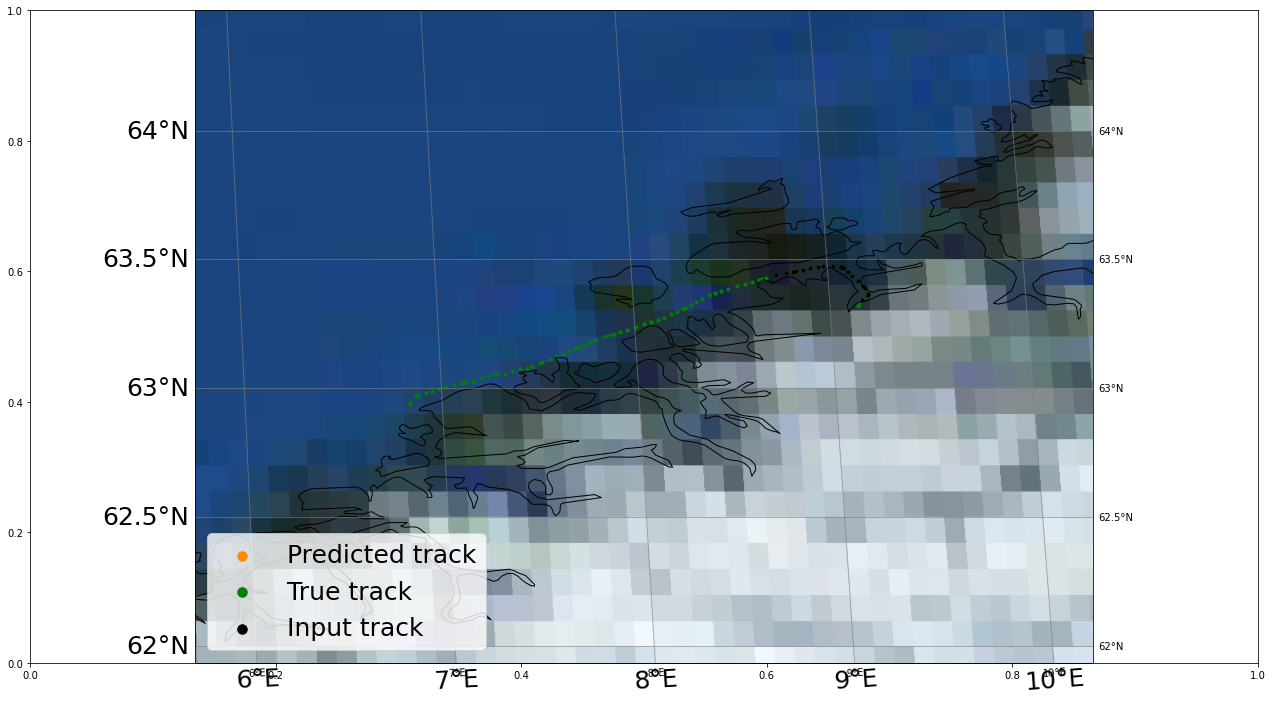

In [127]:
predict_model.predict_test_data(ID_number=test.testing_df.Ids.unique()[160],
                                trajectory_start=0,
                                future_steps=1,
                                norm_which='zscore')
predict_model.plot_prediction()

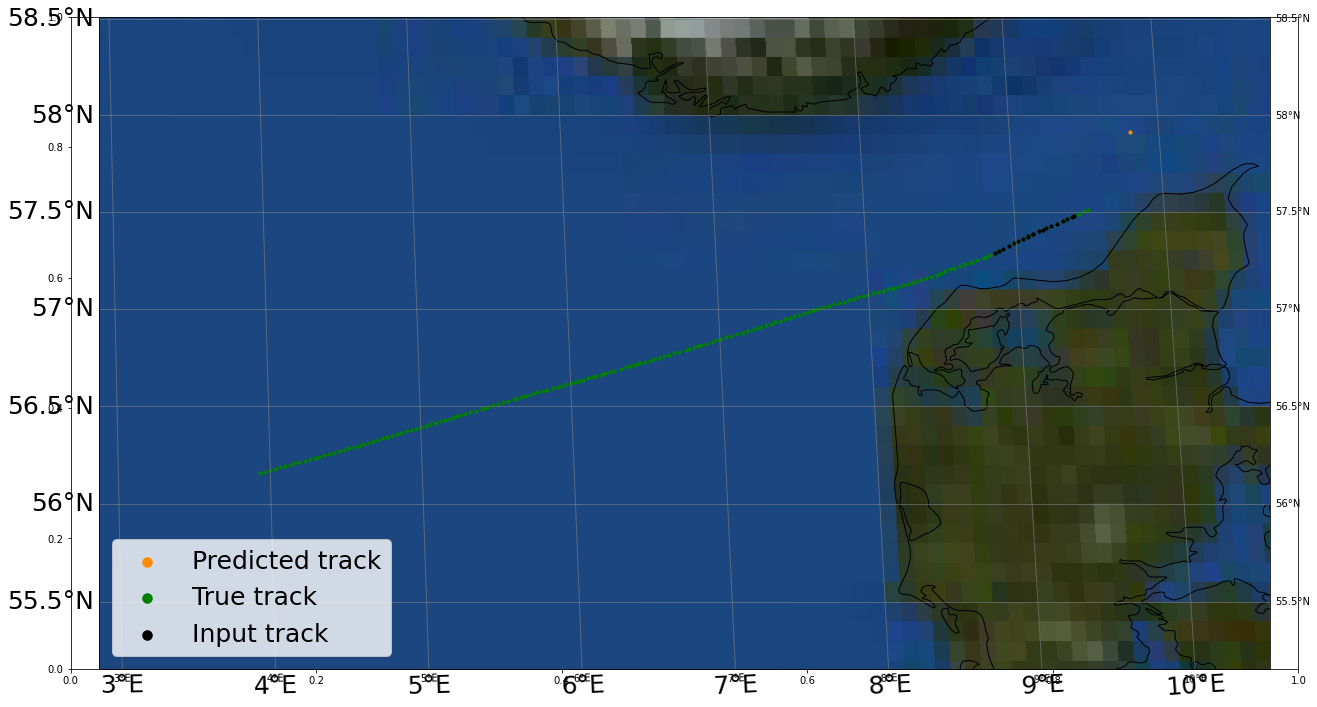

In [ ]:
norm_which.lower() =='zscore':
            for par in self.model_features:
                k = self.samples_description[par]
                pred_sample_features.append(self.predicted_samples[:,i]*self.statistics_training[k]['std']+self.statistics_training[k]['min'])
                i=i+1
            
        self.predicted_samples

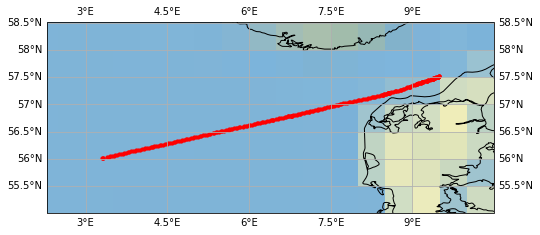

In [68]:
ais_df_process.plot_tracks(test.testing_df[test.testing_df.Ids==test.testing_df.Ids.unique()[70]])

### Explainable AI: Gradients <a class="anchor" id="fifth3-bullet"></a>

cant do blstm_input
cant do flatten
cant do flatten_1
cant do concatenate
cant do dense


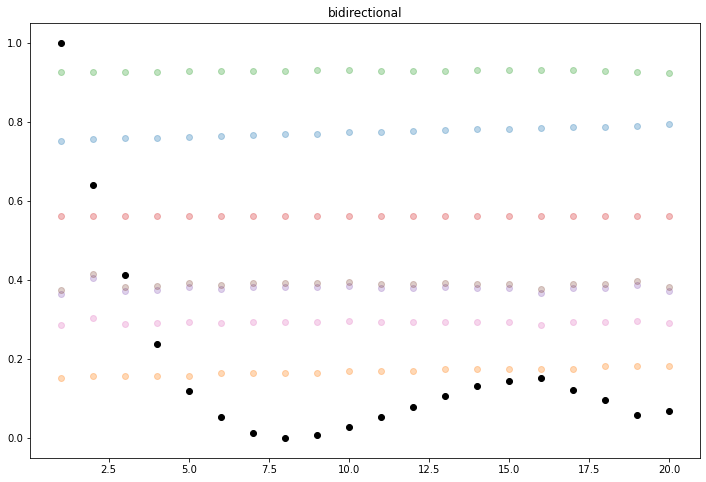

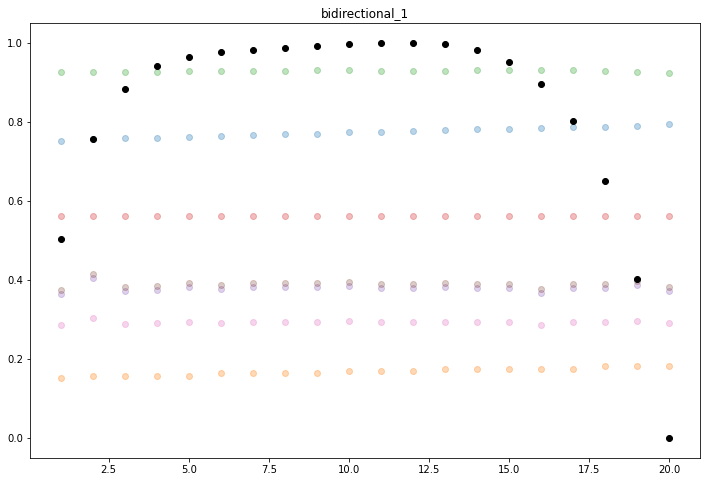

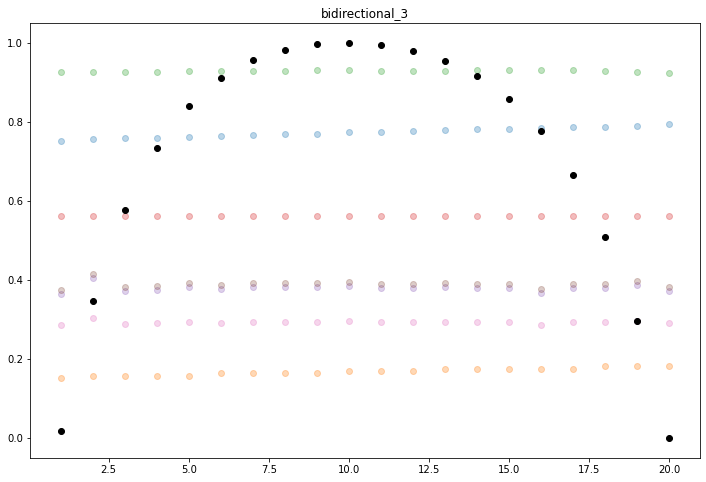

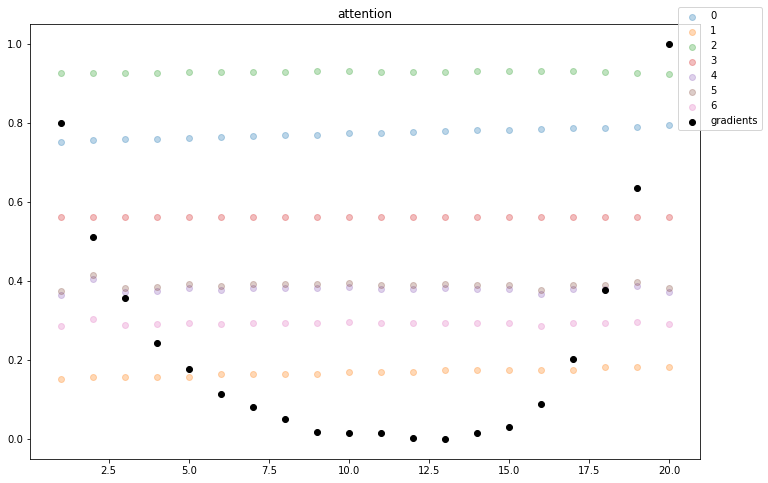

In [43]:
predict_model.get_activation_grad()
predict_model.plot_activation_grads()

# OLD NOT FINISHED

In [ ]:
 -------------------------------------------------
 Test score: 
[0.058206912130117416, 383708.0625, 0.0586748830974102, 0.00032934677437879145, 0.00020526529988273978, 0.001200395985506475, 0.0003996964660473168, 0.00020765727094840258, 0.07195138931274414, 0.0004989231820218265]
-------------------------------------------------

In [203]:
mod.model.summary()

Model: "AIS_forcast_20210913-1636"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 8)]           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 147, 8)            8200      
_________________________________________________________________
conv1d (Conv1D)              (None, 145, 656)          16400     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 145, 656)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 145, 656)          0         
_________________________________________________________________
dropout (Dropout)            (None, 145, 656)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 143, 

```python
Epoch 1/10
34/44 [======================>.......] - ETA: 13s - loss: 0.3097 - Haversine_distance: 2228969.3456 - RMSE_distance: 0.3491 - sog_rmse: 0.0720 - cog_rmse: 0.0694 - distance_rmse: 0.0680 - lat_rmae: 0.0766 - long_rmse: 0.0844 - root_mean_squared_error: 0.3695 - lr: 1.0000e-04
```

In [ ]:
hist = mod.model_fit(batch_size=batch_size,
                         epochs=epochs)

try:
    score= mod.model.evaluate(test.samples_testing.squeeze()[:,:,model_features], 
                            test.targets_testing.squeeze()[:,:,model_features],
                            batch_size=batch_size)
except:
    score= mod.model.evaluate(test.samples_testing.squeeze()[:,:,model_features], 
                            test.targets_testing.squeeze()[:,model_features],
                            batch_size=batch_size)
print(f'\n\n -------------------------------------------------\n Test score: \n{score}')


In [581]:
from scipy import ndimage, misc

def activation_grad(seq, model,layer_name):
    
    #seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer(f'{layer_name}').output, 
                        model.output])    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)    # Get a ponderaated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]    
    time = int(seq.shape[1]/output.shape[0])
    cam = ndimage.zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [345]:
hae.shape

(20,)

In [399]:
alot = test.samples_testing.squeeze()[:,:,model_features].squeeze()[(test.samples_testing.squeeze()[:,:,model_features].squeeze()[:,0,11]>0.8)][0:1,:,:]
alot.shape

(1, 20, 12)

In [434]:
X = test.samples_testing.squeeze()[0:1,:,model_features]
y = test.targets_testing.squeeze()[0:1,:,model_features]

In [435]:
y.shape

(1, 20, 12)

In [ ]:
feat_imp_diz = permut_features_importance(mod.model, X, y, loss_fun=mse, n_repeats=100, 
                                          columns_name=X.columns, seed=42)
feat_imp_mean, feat_imp_std = feat_imp_diz


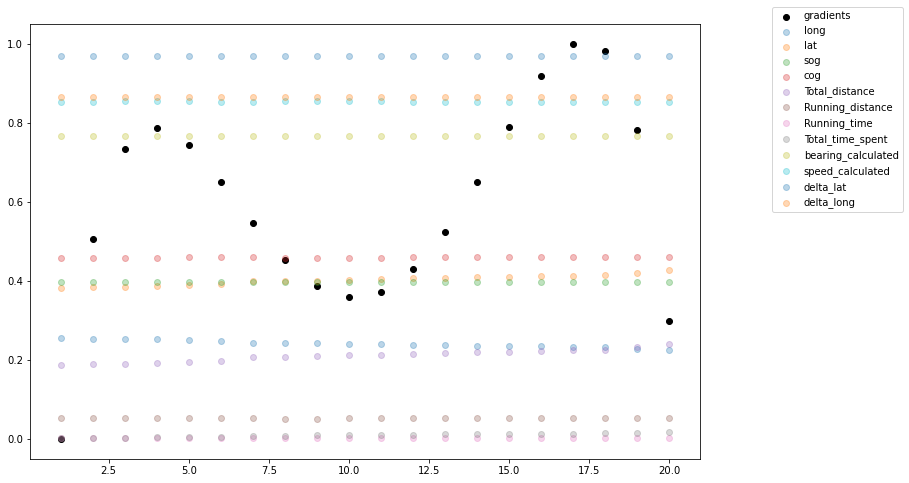

In [403]:
sample_time = 3000


#hae = activation_grad(test.samples_testing.squeeze()[sample_time:sample_time+1,:,model_features],model3,'bidirectional_1')
hae = activation_grad(alot,mod.model,'bidirectional_2')

X = np.linspace(1,len(hae),len(hae))
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(X,hae,label='gradients',c='black')
for i in range(len(model_features)):
    #plt.scatter(X,test.samples_testing.squeeze()[sample_time:sample_time+1,:,model_features].squeeze()[:,i],alpha=0.3,label=test.samples_description[model_features][i])
    plt.scatter(X,alot[0,:,i],alpha=0.3,label=test.samples_description[model_features][i])
    
    

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [404]:
#plt.scatter(np.linspace(1,len(test.samples_testing.squeeze()[:,:,model_features].squeeze()[:,0,0]),len(test.samples_testing.squeeze()[:,:,model_features].squeeze()[:,0,0])),test.samples_testing.squeeze()[:,:,model_features].squeeze()[:,0,0])

In [422]:
def gradient_importance(seq, model,layer_name):
    #np.newaxis[:,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer(f'{layer_name}').output, 
                        model.output])    # Obtain the predicted value and the intermediate filters
    
    with tf.GradientTape() as tape:
        seq_outputs, predictions = model(seq)    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]    # Average gradients spatially

    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import *
from sklearn.datasets import fetch_openml, fetch_california_housing

In [428]:
### UTILITY FUNCTIONS TO SUMMARIZE THE EFFECTS OF ALL THE FEATURES ###

def importance_heatmap(
    imp_values, X, n_bins=5
):
    
    imp_values = np.asarray(imp_values)
    sort_cols = np.argsort(np.mean(np.abs(imp_values), axis=0))[::-1]
    imp_values = imp_values[:,sort_cols]
    X = np.asarray(X)
    X = X[:,sort_cols]
    
    count, bins = np.histogram(imp_values, bins=n_bins)
    bins_inds = np.digitize(imp_values, bins[:-1])
    heatmap = np.zeros((imp_values.shape[1], n_bins)) *np.nan

    for c in range(imp_values.shape[1]):

        _ndx = np.argsort(bins_inds[:,c])
        _id, _pos, g_count  = np.unique(bins_inds[_ndx,c], 
                                        return_index=True, 
                                        return_counts=True)
        g_sum = np.add.reduceat(X[_ndx,c], _pos)
        g_mean = g_sum / g_count
        _id -= 1
        
        heatmap[np.ix_([c],_id)] = g_mean
        
        nan = np.isnan(heatmap[c])
        not_nan = np.logical_not(nan)
        interpolated = np.interp(nan.nonzero()[0], not_nan.nonzero()[0], g_mean)
        heatmap[np.ix_([c],nan)] = interpolated
        
    return heatmap, bins, sort_cols

def plot_importance_heatmap(
    imp_values, X, 
    n_bins=5, max_display=20, 
    feat_name=None
):
    
    heatmap, bins, sort_cols = importance_heatmap(imp_values, X, n_bins=n_bins)
    max_display = min(sort_cols.shape[0], max_display)
    heatmap = heatmap[:max_display]
    masks = np.asarray([np.arange(max_display)]*n_bins).T
    null = np.argmin(np.abs(bins))
    
    for m in range(masks.shape[0]):
        plt.imshow(np.ma.masked_array(heatmap, masks != m), cmap='plasma')
    
    if feat_name is None:
        feat_name = [f"feat_{c}" for c in sort_cols]
    else:
        feat_name = [feat_name[c] for c in sort_cols]
    
    plt.yticks(range(max_display), feat_name[:max_display])
    plt.colorbar(ticks=[-1], aspect=50, label='Feature values')
    plt.axvline(null, c='lime', linestyle='--')
    plt.xticks([0, null, n_bins-1], ['negative', 'null', 'positive'])
    plt.ylabel('Features (sorted by importance)')
    plt.xlabel('Permutation values (impact on model output)')
    
### UTILITY FUNCTION FOR FEATURES PERMUTATION IMPORTANCE ###

def permut_features_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    seed=None, columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if seed is not None:
        np.random.seed(seed)
    
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
        
    error = loss_fun(model, X, y)
    features_imp = {}
    std_features_imp = {}     
        
    for col in tqdm(range(X.shape[-1])):
        
        _importance = []
        for _ in range(n_repeats):
            
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            _importance.append(loss_fun(model, _X, y) - error)
                
        features_imp[columns_name[col]] = np.mean(_importance)
        std_features_imp[columns_name[col]] = np.std(_importance)
                
    return features_imp, std_features_imp


### UTILITY FUNCTION FOR SAMPLES PERMUTATION IMPORTANCE ###

def permut_sample_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    alpha=None, seed=None, columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if alpha is not None:
        assert alpha > 0 and alpha < 1
        
    if seed is not None:
        np.random.seed(seed)
        
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
    
    dist_error = loss_fun(model, X, y, normalize=False)
    sample_imp = {}
    
    for col in tqdm(range(X.shape[-1])):
        
        _importance = []
        for _ in range(n_repeats):
        
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            dist_error_perm = loss_fun(model, _X, y, normalize=False)
            _importance.append(dist_error_perm - dist_error)
        
        if alpha is None:
            sample_imp[columns_name[col]] = np.quantile(
                np.asarray(_importance), 
                q = 0.5, axis = 0)
        else:
            sample_imp[columns_name[col]] = np.quantile(
                np.asarray(_importance), 
                q = [alpha/2, 0.5, 1-alpha/2], axis = 0).T
            
    return sample_imp


### UTILITY FUNCTIONS TO SUMMARIZE THE EFFECTS OF ALL THE FEATURES ###

def importance_heatmap(
    imp_values, X, n_bins=5
):
    
    imp_values = np.asarray(imp_values)
    sort_cols = np.argsort(np.mean(np.abs(imp_values), axis=0))[::-1]
    imp_values = imp_values[:,sort_cols]
    X = np.asarray(X)
    X = X[:,sort_cols]
    
    count, bins = np.histogram(imp_values, bins=n_bins)
    bins_inds = np.digitize(imp_values, bins[:-1])
    heatmap = np.zeros((imp_values.shape[1], n_bins)) *np.nan

    for c in range(imp_values.shape[1]):

        _ndx = np.argsort(bins_inds[:,c])
        _id, _pos, g_count  = np.unique(bins_inds[_ndx,c], 
                                        return_index=True, 
                                        return_counts=True)
        g_sum = np.add.reduceat(X[_ndx,c], _pos)
        g_mean = g_sum / g_count
        _id -= 1
        
        heatmap[np.ix_([c],_id)] = g_mean
        
        nan = np.isnan(heatmap[c])
        not_nan = np.logical_not(nan)
        interpolated = np.interp(nan.nonzero()[0], not_nan.nonzero()[0], g_mean)
        heatmap[np.ix_([c],nan)] = interpolated
        
    return heatmap, bins, sort_cols

def plot_importance_heatmap(
    imp_values, X, 
    n_bins=5, max_display=20, 
    feat_name=None
):
    
    heatmap, bins, sort_cols = importance_heatmap(imp_values, X, n_bins=n_bins)
    max_display = min(sort_cols.shape[0], max_display)
    heatmap = heatmap[:max_display]
    masks = np.asarray([np.arange(max_display)]*n_bins).T
    null = np.argmin(np.abs(bins))
    
    for m in range(masks.shape[0]):
        plt.imshow(np.ma.masked_array(heatmap, masks != m), cmap='plasma')
    
    if feat_name is None:
        feat_name = [f"feat_{c}" for c in sort_cols]
    else:
        feat_name = [feat_name[c] for c in sort_cols]
    
    plt.yticks(range(max_display), feat_name[:max_display])
    plt.colorbar(ticks=[-1], aspect=50, label='Feature values')
    plt.axvline(null, c='lime', linestyle='--')
    plt.xticks([0, null, n_bins-1], ['negative', 'null', 'positive'])
    plt.ylabel('Features (sorted by importance)')
    plt.xlabel('Permutation values (impact on model output)')

In [423]:
grads = gradient_importance(alot,mod.model,'bidirectional_2')

ValueError: not enough values to unpack (expected 2, got 1)

In [421]:
grads

-0.0043866714

In [638]:
test.samples_testing.squeeze()[0:1,:,model_features].squeeze().shape

(20, 16)

In [64]:
from lime import lime_tabular
import lime

In [71]:
mod.model.summary()

Model: "AIS_forcast_20210909-1047"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 20, 16)]     0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 20, 16)       0           encoder_input[0][0]              
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 656)      905280      masking[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 20, 656)      0           bidirectional[0][0]              
__________________________________________________________________________

In [86]:
model3 = mod.model

In [155]:
def predict(x):
    global model3
    qc = model3.predict([x])
    #.flatten()
    #qc.reshape(qc.shape[2]*qc.shape[1]).squeeze()
    return qc.reshape(1, -1)

In [196]:
explainer = lime_tabular.RecurrentTabularExplainer(test.samples_training.squeeze()[0:50000:50,:,model_features], 
                                                   training_labels=test.targets_training.squeeze()[0:50000:50,:,model_features], 
                                                   feature_names=test.samples_description[model_features],
                                                   mode='regression',
                                                   feature_selection = 'forward_selection',
                                                   verbose=True,
                                                   random_state=42)

In [197]:
exp = explainer.explain_instance(test.samples_testing[0:1,:,model_features],predict,num_samples=1, num_features=320)

Intercept 0.625236451625824
Prediction_local [0.62523645]
Right: 0.62523645


The local prediction is generated by a simple model that was trained on a combination of m best feature permuted data and similarity scores data. We can see that it’s quite close to the actual prediction using our complex model.

In [199]:
print("Explanation Local Prediction  : ", exp.local_pred)
print("Explanation Global Prediction : ", exp.predicted_value)

Explanation Local Prediction  :  [0.62523645]
Explanation Global Prediction :  0.62523645


In [200]:
!pwd

/work3/kaaso/phd/AIS_prediction


In [209]:
test.samples_testing[0:1,:,model_features].squeeze().shape

(20, 16)

In [201]:
from delete.lime_timeseries import LimeTimeSeriesExplainer

In [202]:
explainer2 = LimeTimeSeriesExplainer()

In [211]:
test1 = test.samples_testing[0:1,:,model_features].squeeze()

In [220]:
from lime import explanation
from lime import lime_base

In [231]:
exp2 = explainer2.explain_instance(test.samples_testing[0:1,:,model_features].squeeze(),
                                   model3, 
                                   num_features=16, 
                                   num_samples=1, num_slices=10, 
                                   replacement_method='noise')
exp2.as_pyplot_figure()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [173]:
#exp.show_in_notebook()

In [165]:
feature_importance = exp.as_list()

In [176]:
%matplotlib inline

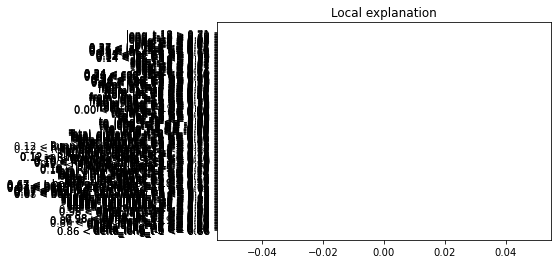

In [193]:

fig = exp.as_pyplot_figure()

In [21]:
from tensorflow import keras
modellen = keras.models.load_model('AIS_forcast_20210906-1804/best_model_AIS_forcast_20210906-1804.h5', custom_objects={'loss_function': Haversine_loss(6356.752),
                                                                                                                     'Haversine_distance':Haversine(6356.752),
                                                                                                                     'RMSE_distance':rmse_coordinates(),
                                                                                                                     'sog_rmse':diff_sog,
                                                                                                                     'cog_rmse':diff_cog,
                                                                                                                     'distance_rmse':diff_dist,
                                                                                                                     'lat_rmae':diff_lat,
                                                                                                                     'long_rmse':diff_long,
                                                                                                                     'lr':get_lr_metric})


In [105]:
ss = pd.read_pickle('20210913-17_Thesis_model/history_newest_epoch_20210913-17_Thesis_model.pkl')

In [107]:
ss.tail()

,loss,Haversine_distance,RMSE_distance,sog_rmse,cog_rmse,distance_rmse,lat_rmae,long_rmse,root_mean_squared_error,lr,val_loss,val_Haversine_distance,val_RMSE_distance,val_sog_rmse,val_cog_rmse,val_distance_rmse,val_lat_rmae,val_long_rmse,val_root_mean_squared_error,val_lr
366,0.009653,67348.460938,0.009651,0.000014,0.000191,0.000118,4.982918e-08,4.615123e-09,0.073436,0.000002,0.004032,20312.001953,0.003869,0.000107,0.000187,0.000148,5.341155e-08,4.288587e-08,0.071846,0.000002
367,0.009593,66913.367188,0.009587,0.000013,0.000192,0.000117,3.641540e-08,1.146293e-08,0.073441,0.000002,0.004033,20373.519531,0.003871,0.000107,0.000186,0.000149,7.635545e-08,4.634008e-08,0.071836,0.000002
368,0.009618,67100.687500,0.009608,0.000014,0.000189,0.000119,3.213175e-08,7.602344e-09,0.073439,0.000001,0.004032,20379.611328,0.003870,0.000107,0.000185,0.000149,8.158308e-08,4.704799e-08,0.071858,0.000001
369,0.009660,67499.867188,0.009654,0.000014,0.000190,0.000118,5.444025e-08,2.565962e-08,0.073464,0.000001,0.004028,20244.255859,0.003867,0.000106,0.000187,0.000147,4.520155e-08,6.514417e-08,0.071839,0.000001
370,0.009600,67254.968750,0.009587,0.000013,0.000194,0.000116,1.225742e-08,3.052379e-09,0.073404,0.000001,0.004039,20392.431641,0.003877,0.000107,0.000185,0.000149,9.224668e-08,4.963744e-08,0.071816,0.000001


In [108]:
from tensorflow import keras
modellen = keras.models.load_model('20210913-17_Thesis_model/best_model_20210913-17_Thesis_model.h5', custom_objects={'loss_function': Haversine_loss(6356.752),
                                                                                                                     'Haversine_distance':Haversine(6356.752),
                                                                                                                     'RMSE_distance':rmse_coordinates(),
                                                                                                                     'sog_rmse':diff_sog,
                                                                                                                     'cog_rmse':diff_cog,
                                                                                                                     'distance_rmse':diff_dist,
                                                                                                                     'lat_rmae':diff_lat,
                                                                                                                     'long_rmse':diff_long,
                                                                                                                     'lr':get_lr_metric})


In [109]:
modellen.summary()

Model: "20210913-17_Thesis_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 20, 8)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 712)      1039520     encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 712)      2848        bidirectional[0][0]              
__________________________________________________________________________________________________
dropout (Dropout)               (None, 20, 712)      0           batch_normalization[0][0]        
___________________________________________________________________________

In [ ]:
from tensorflow import keras
modellen = keras.models.load_model('AIS_forcast_20210906-1804/best_model_AIS_forcast_20210906-1804.h5', custom_objects={'loss_function': Haversine_loss(6356.752),
                                                                                                                     'Haversine_distance':Haversine(6356.752),
                                                                                                                     'RMSE_distance':rmse_coordinates(),
                                                                                                                     'sog_rmse':diff_sog,
                                                                                                                     'cog_rmse':diff_cog,
                                                                                                                     'distance_rmse':diff_dist,
                                                                                                                     'lat_rmae':diff_lat,
                                                                                                                     'long_rmse':diff_long,
                                                                                                                     'lr':get_lr_metric})


In [94]:
#modellen = mod.model

In [646]:
test.testing_df.Ids.unique()[:10]

array([ 47,  58,  89, 113, 198, 211, 281, 296, 588, 632])

In [66]:
test.statistics_training

,long,lat,sog,cog,Ids,from_lat,from_long,to_lat,to_long,Total_distance,Distance_percentage,Running_distance,time_left,Running_time,Total_time_spent,bearing_calculated,speed_calculated,delta_lat,delta_long
count,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000,1.073320e+05,107332.000000,107332.000000,107332.000000,107332.000000,107332.000000
mean,13.616814,54.912561,9.869052,184.976969,36993.193288,56.233098,15.608402,55.677049,14.357527,15.303484,0.506352,2.542868,1324.866857,4.417464e+04,7171.465011,130.471413,2.088021,-0.035740,-0.010222
std,0.327448,0.181733,4.102688,94.528783,26818.559618,2.722416,5.859787,2.398369,5.076610,9.680811,0.292588,25.481321,1012.492808,4.805454e+05,8416.233450,572.334096,55.428648,0.445565,0.201325
min,13.079831,53.939428,-44.523319,-115.236090,46.000000,53.421466,5.028651,53.421466,5.052108,-7.953848,-0.272486,-7.331039,26.000714,-1.680189e+04,-134.843162,-8576.928587,-826.202661,-8.304127,-4.435151
25%,13.378000,54.761500,8.357143,94.000000,12950.000000,54.364470,10.140031,54.364470,10.140031,7.427462,0.255240,0.112817,699.845000,4.450000e+01,2831.000000,91.286492,8.032166,-0.001675,-0.009658
50%,13.587357,54.915000,9.489396,244.725278,30599.000000,55.040396,13.590934,54.481985,12.600093,14.772101,0.506970,0.356901,944.350000,1.395000e+02,5757.833333,244.424756,9.287035,-0.000142,-0.000961
75%,13.804280,55.025000,10.733333,262.400000,67443.000000,56.987249,21.007030,56.152057,18.528595,22.403722,0.757728,0.761875,1689.524184,3.000000e+02,9002.019717,262.230753,10.492630,0.000920,0.007451
max,16.521578,55.446759,53.525323,699.710205,82603.000000,66.315896,30.247549,69.666298,30.247549,71.343934,1.296715,520.918545,7570.058750,8.328644e+06,117913.000000,1302.354124,43.380247,0.217051,0.758891


In [108]:
#test.samples_testing[test.samples_testing[:,:,4]==58]

In [145]:
test.testing_df.Ids.unique()[0:10]

array([ 47,  58,  89, 113, 198, 211, 281, 296, 588, 632])

In [20]:
modellen = mod.model

In [128]:
test.samples_testing.shape

(1035751, 20, 13)

In [23]:

predict_model = use_model(modellen,
                          test.targets_testing,
                         test.samples_testing,
                         test.samples_description,
                         model_features,
                         test.statistics_training)

predict_model.predict_test_data(ID_number=89,
                                trajectory_start=20,
                                future_steps=10,
                                norm_which='minmax')
#predict_model.get_activation_grad()

(38, 19)
(19, 38)


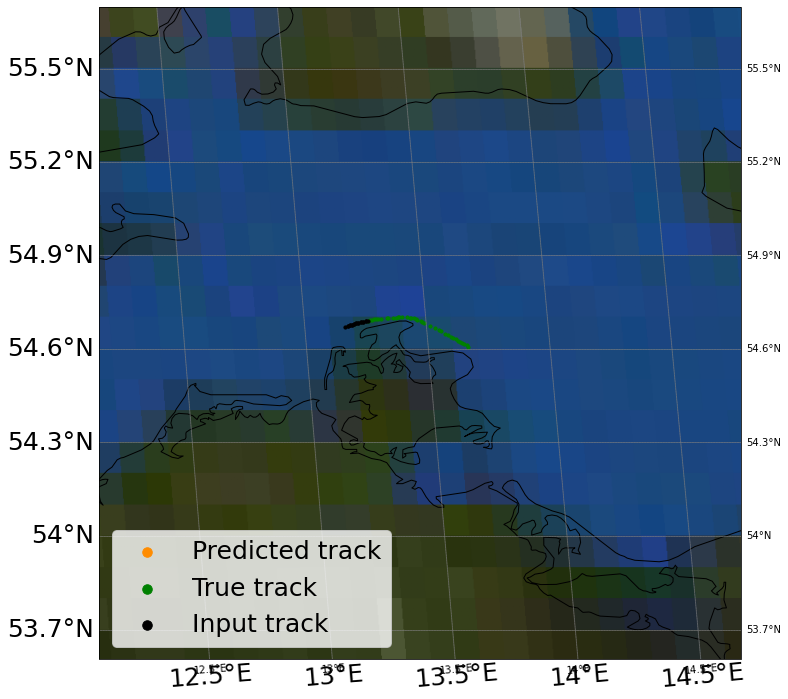

In [24]:
predict_model.plot_prediction()

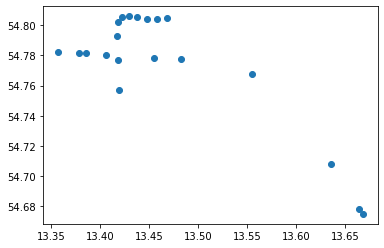

In [30]:
plt.scatter(predict_model.predicted_samples[0],predict_model.predicted_samples[1])

In [126]:
predict_model.samples_testing[:,:,4]

array([[4.7000e+01, 4.7000e+01, 4.7000e+01, ..., 4.7000e+01, 4.7000e+01,
        4.7000e+01],
       [4.7000e+01, 4.7000e+01, 4.7000e+01, ..., 4.7000e+01, 4.7000e+01,
        4.7000e+01],
       [4.7000e+01, 4.7000e+01, 4.7000e+01, ..., 4.7000e+01, 4.7000e+01,
        4.7000e+01],
       ...,
       [8.2633e+04, 8.2633e+04, 8.2633e+04, ..., 8.2633e+04, 8.2633e+04,
        8.2633e+04],
       [8.2633e+04, 8.2633e+04, 8.2633e+04, ..., 8.2633e+04, 8.2633e+04,
        8.2633e+04],
       [8.2633e+04, 8.2633e+04, 8.2633e+04, ..., 8.2633e+04, 8.2633e+04,
        8.2633e+04]])

In [158]:
predict_model.corrected_target.shape

(19, 28)

In [127]:
#plt.scatter(predict_model.predicted_samples[0,18:],np.linspace(1,len(predict_model.predicted_samples[1,18:]),len(predict_model.predicted_samples[1,18:])))

In [128]:
#plt.scatter(predict_model.predicted_samples[1,18:],predict_model.predicted_samples[0,18:])

In [129]:
#plt.scatter(predict_model.corrected_samples[model_features,:][0,1:],predict_model.corrected_samples[model_features,:][1,1:])

In [130]:
#weights, heatmap = predict_model.activation_grad(layer_name = 'bidirectional_1')

In [137]:
predict_model.samples_testing[test.samples_testing[:,:,4]==47].shape

(380, 19)

In [138]:
predict_model.targets_testing[test.targets_testing[:,:,4]==47].shape

(19, 19)

In [148]:
predict_model.samples_description

Index(['long', 'lat', 'sog', 'cog', 'Ids', 'from_lat', 'from_long', 'to_lat',
       'to_long', 'Total_distance', 'Distance_percentage', 'Running_distance',
       'time_left', 'Running_time', 'Total_time_spent', 'bearing_calculated',
       'speed_calculated', 'delta_lat', 'delta_long'],
      dtype='object')

In [624]:
te = 'dropout'
ti = 'bir'

In [625]:
te.startswith( 'drop' )

True

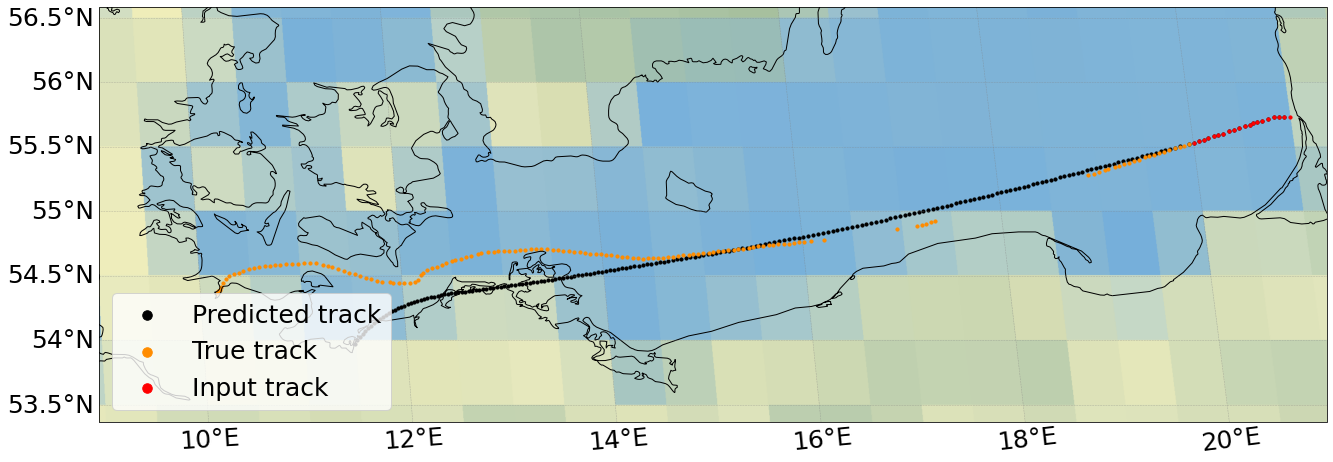

In [471]:
plot_prediction(pred_sample_features,true_target_features,true_features)

In [419]:
with open(f'test1.pickle', 'rb') as file2:
    s1_new = pickle.load(file2)

,long,lat,sog,cog,Ids,from_lat,from_long,to_lat,to_long,Total_distance,Distance_percentage,Running_distance,time_left,Running_time,Total_time_spent,bearing_calculated,speed_calculated,delta_lat,delta_long
count,54627.000000,54627.000000,54627.000000,54627.000000,54627.000000,54627.000000,54627.000000,5.462700e+04,5.462700e+04,54627.000000,54627.000000,54627.000000,54627.000000,5.462700e+04,54627.000000,54627.000000,54627.000000,54627.000000,54627.000000
mean,16.443812,55.732143,9.370241,255.411809,50172.742911,56.489385,22.982264,5.436447e+01,1.014003e+01,249.010534,0.499778,13.788632,1635.510206,6.277090e+03,98033.967776,253.705941,9.327670,-0.065177,-0.387010
std,3.833762,1.095885,1.944427,45.112192,26188.139233,0.633241,1.458509,2.972718e-14,5.374130e-15,150.702104,0.290121,111.152087,1034.616072,5.455919e+04,62059.681735,26.022232,2.069394,0.481703,3.154415
min,10.160000,54.359000,-1.879507,14.980000,198.000000,55.683971,21.127197,5.436447e+01,1.014003e+01,0.050572,0.000092,-269.593558,0.340000,-9.733101e+04,0.000000,9.121598,-6.700074,-11.167058,-79.459486
25%,13.137750,54.768000,8.450000,239.400000,27273.000000,55.683971,21.127197,5.436447e+01,1.014003e+01,121.405028,0.248681,0.242957,772.633333,9.600000e+01,46261.841880,239.327812,8.440265,-0.005994,-0.022597
50%,16.333000,55.487000,9.253846,248.609381,66720.000000,56.987249,24.128966,5.436447e+01,1.014003e+01,241.940916,0.496463,0.647008,1548.880000,2.520000e+02,92826.461538,248.554726,9.278230,-0.002261,-0.015867
75%,19.525613,56.734159,10.150000,264.950000,70540.000000,56.987249,24.128966,5.436447e+01,1.014003e+01,365.429598,0.750557,0.848428,2382.113373,3.055000e+02,142775.250000,264.949138,10.155171,-0.000436,-0.005887
max,24.006000,57.867467,23.000000,1294.925349,82598.000000,56.987249,24.128966,5.436447e+01,1.014003e+01,630.306207,1.000000,2793.435618,5190.650000,1.303595e+06,311210.888889,347.941495,28.354669,0.141256,8.500624


In [440]:
!pwd

/work3/kaaso/phd/AIS_prediction


In [116]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
def plot_prediction(pred_sample_features,true_target_features,true_features):
    '''
    
    '''
    
    #import seaborn as sns
    #seaborn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    projections = [ccrs.PlateCarree(),
                   ccrs.Robinson(),
                   ccrs.Mercator(),
                   ccrs.Orthographic(),
                   ccrs.InterruptedGoodeHomolosine()
                  ]



    cmap_reversed = cm.get_cmap('magma_r')

    fig = plt.subplots(figsize=(22,12))
    ax = plt.axes(projection=projections[1])
    #ax.set_extent([pred[:,0].min()-6,pred[:,0].max()+3,pred[:,1].min()-5,pred[:,1].max()+2], crs=ccrs.PlateCarree())
    #ax.set_extent([ pred_sample_features[0,:].min()-1, pred_sample_features[0,:].max()+1,pred_sample_features[1,:].min()-1, pred_sample_features[1,:].max()+1])
    ax.set_extent([ true_target_features[0,:].min()-1, true_target_features[0,:].max()+1,true_target_features[1,:].min()-1, true_target_features[1,:].max()+1])

    ax.stock_img()


    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    #plt.scatter(samples[:20,0],samples[:20,1],s=10,c='black',transform=ccrs.PlateCarree(),label='Input track')
    #plt.scatter(samples[20:,0],samples[20:,1],s=10,c='green',alpha=0.7,cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Future track')
    #plt.scatter(samples[0,0],samples[0,1],color='red',s=35,cmap=cmap_reversed,transform=ccrs.PlateCarree())
    cmap=cm.get_cmap("hsv",360)
    #plt.scatter(pred_long[:,0],pred_lat[:,0],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Predicted track')

    plt.scatter(pred_sample_features[0,:],pred_sample_features[1,:],s=10,color='black',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Predicted track')
    #plt.scatter(pred_sample_features[0,:20],pred_sample_features[1,:20],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='input')
    plt.scatter(true_target_features[0,:],true_target_features[1,:],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='True track')
    plt.scatter(true_features[0,:20],true_features[1,:20],s=10,color='red',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Input track')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 25}
    gl.ylabel_style = {'size': 25}
    plt.legend(loc="lower left", fontsize=25,markerscale=3)

In [460]:
true_target_features.shape

(19, 220)

In [24]:
def predict_test_data(ID_number,
                      model,
                      samples_testing,
                      targets_testing,
                      samples_description,
                      statistics_training,
                      future_steps=100):
    '''
    
    '''
    samples_id = samples_testing[samples_testing[:,:,4]==ID_number]
    targets_id = targets_testing[targets_testing[:,:,4]==ID_number]
    #samples_id = test.samples_training[test.samples_training[:,:,4]==ID_number]
    #targets_id = test.samples_training[test.samples_training[:,:,4]==ID_number]
    samples_id_start = samples_id[:20,:]

    true_sample_features = []
    true_target_features = []
    i = 0
    for par in samples_description:
        #k = test.samples_description[par]
        #ind = list(filter(lambda i: list(test.samples_description==par)[i], range(len(list(test.samples_description==par)))))
        true_sample_features.append((samples_id_start[:,i]*(statistics_training[par]['max']-statistics_training[par]['min'])+statistics_training[par]['min']))
        true_target_features.append((targets_id[:,i]*(statistics_training[par]['max']-statistics_training[par]['min'])+statistics_training[par]['min']))
        i=i+1
        
    true_sample_features = np.array(true_sample_features)
    true_target_features = np.array(true_target_features)


    li = (samples_testing[:,:,4]==ID_number)[:,0]
    te = [i for i, x in enumerate(li) if x]
    sample_id = samples_testing.squeeze()[li[0]:li[0]+1,:,model_features]
    pred= predict_future(model,sample_id,future_steps=future_steps)


    pred_sample_features = []
    i = 0
    for par in model_features:
        k = samples_description[par]
        #ind = list(filter(lambda i: list(test.samples_description==par)[i], range(len(list(test.samples_description==par)))))
        pred_sample_features.append((pred[:,i]*(statistics_training[k]['max']-statistics_training[k]['min'])+statistics_training[k]['min']))
        i=i+1
    pred_sample_features = np.array(pred_sample_features)
    
    
    return true_sample_features, true_target_features, pred_sample_features

In [462]:
true_features.shape

(19, 20)

Running_distance


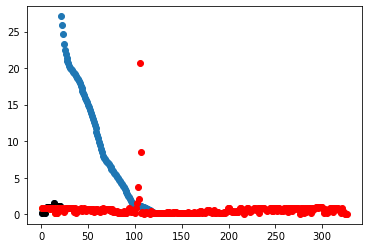

In [384]:
i =9
print(test.samples_description[model_features[i]])
plt.scatter(np.linspace(1, len(pred_sample_features[2,:]),len(pred_sample_features[2,:])),pred_sample_features[i,:])
plt.scatter(np.linspace(1, len(pred_sample_features[2,:]),len(pred_sample_features[2,:]))[:20],pred_sample_features[i,:20],c='black')
#plt.scatter(np.linspace(1, len(corr_features[2,:]),len(corr_features[2,:])),corr_features[i,:])
plt.scatter(np.linspace(1, len(true_target_features[2,:]),len(true_target_features[2,:]))[:20],true_target_features[model_features[i],:20],c='orange')
plt.scatter(np.linspace(1, len(true_target_features[2,:]),len(true_target_features[2,:]))[:],true_target_features[model_features[i],:],c='red')

In [400]:
np.array(true_sample_features).shape

(19, 20)

In [401]:
true_sample_features.shape

AttributeError: 'list' object has no attribute 'shape'

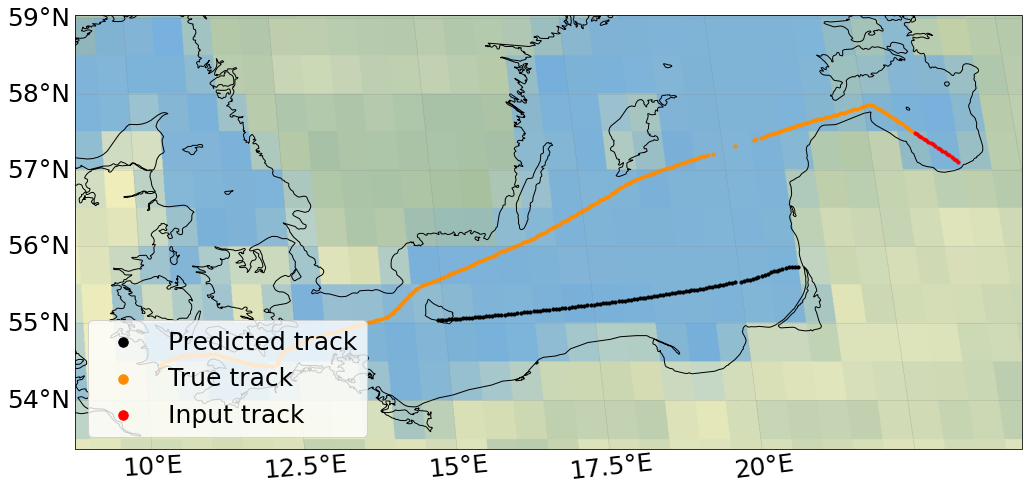

In [405]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
#import seaborn as sns
#seaborn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
projections = [ccrs.PlateCarree(),
               ccrs.Robinson(),
               ccrs.Mercator(),
               ccrs.Orthographic(),
               ccrs.InterruptedGoodeHomolosine()
              ]

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

cmap_reversed = cm.get_cmap('magma_r')

fig = plt.subplots(figsize=(20,8))
ax = plt.axes(projection=projections[1])
#ax.set_extent([pred[:,0].min()-6,pred[:,0].max()+3,pred[:,1].min()-5,pred[:,1].max()+2], crs=ccrs.PlateCarree())
ax.set_extent([ true_target_features[0,:].min()-1, true_target_features[0,:].max()+1,true_target_features[1,:].min()-1, true_target_features[1,:].max()+1])
ax.stock_img()


SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

#plt.scatter(samples[:20,0],samples[:20,1],s=10,c='black',transform=ccrs.PlateCarree(),label='Input track')
#plt.scatter(samples[20:,0],samples[20:,1],s=10,c='green',alpha=0.7,cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Future track')
#plt.scatter(samples[0,0],samples[0,1],color='red',s=35,cmap=cmap_reversed,transform=ccrs.PlateCarree())
cmap=cm.get_cmap("hsv",360)
#plt.scatter(pred_long[:,0],pred_lat[:,0],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Predicted track')

plt.scatter(pred_sample_features[0,:],pred_sample_features[1,:],s=10,color='black',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Predicted track')
#plt.scatter(pred_sample_features[0,:20],pred_sample_features[1,:20],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='input')
plt.scatter(true_target_features[0,:],true_target_features[1,:],s=10,color='darkorange',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='True track')
plt.scatter(true_features[0,:20],true_features[1,:20],s=10,color='red',cmap=cmap,vmin=0, vmax=360,transform=ccrs.PlateCarree(),label='Input track')



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
plt.legend(loc="lower left", fontsize=25,markerscale=3)

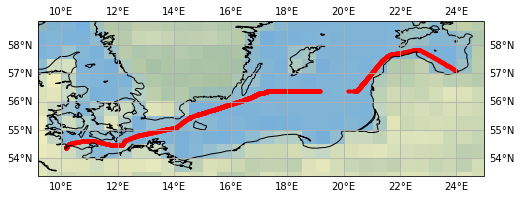

In [372]:
ais_df_process.plot_tracks(test.testing_df[test.testing_df.Ids==ID])

282

In [41]:
test.statistics_training.long['min']

16

In [26]:
def predict_future(model,sample,future_steps=100):
    '''
    
    '''
    input_sample = sample.squeeze()
    lookback = input_sample.shape[0]
    features = input_sample.shape[1]
    current_input = input_sample
    if future_steps>1:
        for k in range(future_steps):
            this_input = current_input[-lookback:,:]
            #print(this_input.shape)
            this_input_pred = np.reshape(this_input,(1,lookback,features))
            #print(this_input_pred.shape)
            this_prediction = model.predict(this_input_pred)  
            #print(this_prediction.shape)
            current_input = np.vstack((current_input,this_prediction))
        predicted_track =   current_input 
    else:
        this_input_pred = np.reshape(sample,(1,-1))
        predicted_track =   model.predict(this_input_pred)  
        
    
     
    #predicted_track = current_input[:,1:3].copy()
    #redicted_track = predicted_track*std+mean

    return predicted_track





In [ ]:



#pred2= predict_future(model,data[9,:,1:],future_steps=10)
#pred2 = pred2*std_training[2:]+mean_training[2:]

#pred3= predict_future(model,data[8,:,1:],future_steps=10)
#pred3 = pred3*std_training[2:]+mean_training[2:]
#samples =
#samples1 =X_val_samples[n+20,:,:]*std_training+mean_training
samples= X_val_samples[n,:,:]*std_training+mean_training
for i in range(20,future_steps-40,20):
    samples = np.vstack((samples,X_val_samples[n+i,:,:]*std_training+mean_training))
samples = np.array(samples)

In [5]:
%matplotlib widget

from tensorflow.keras import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
import tensorflow as tf
from tensorflow.keras.regularizers import l2

#general 
import numpy as np
import pandas as pd
import math
import os
import keras.backend as K
import tensorflow as tf
# RNN, deep leraning ect.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#import tf.keras.layers.MultiHeadAttention 
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Masking
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed, Dropout, Bidirectional,concatenate
import datetime
import tensorflow_addons as tfa
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Flatten,Concatenate,Attention,Add,BatchNormalization,MultiHeadAttention
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, SimpleRNN, GRU, TimeDistributed, ConvLSTM2D, RNN,Conv1D
from tensorflow.keras.layers import RepeatVector, Input, Flatten
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import TimeDistributed, Attention
#plotting
#import gdal
#import osr
#import geopandas as gpd
#import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
import datetime, os

from tensorflow.keras.layers import Dense,LSTM, Dropout, Bidirectional, SimpleRNN, GRU, TimeDistributed, Input, RNN,RepeatVector,Masking,TimeDistributed,BatchNormalization






from keras.callbacks import LambdaCallback   

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import random
import os


def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(seed=3)

In [ ]:
model = Encoder_attention_prediction()
model.enocoder_attention_inputs()
prediction = model.build_encoder_attention()
prediction.summary()

In [363]:
model = EncoderDecoder()
model.enocoder_decoder_inputs()
prediction = model.build_encoder()
prediction.summary()

Model: "20210722-154915_Encoder_Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_dynamic_inputs (InputLa [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
encoder_static_inputs (InputLay [(None, 1923)]       0                                            
__________________________________________________________________________________________________
Encoder_model (Functional)      (None, 200)          1672232     encoder_dynamic_inputs[0][0]     
                                                                 encoder_static_inputs[0][0]      
__________________________________________________________________________________________________
Decoder_model (Functional)      (None, 5)            1647797     Enc

In [387]:
  
from keras.utils.layer_utils import count_params

class EncoderDecoderAttention:
    '''
    '''
    def __init__(self, 
                 encoder_decoder_name:str = 'Encoder_Decoder',
                 encoder_hidden_layers:list = [256,128],
                 decoder_hidden_layers:list = [256,128],
                 kernel_initializer:str ='glorot_uniform' , 
                 kernel_regularizer:float = 0.0001,
                 bias_regularizer:float = 0.0001,
                 recurrent_regularizer:float = 0.0001,
                 dynamic_dropout:float = 0.2,
                 combiend_dropout:float = 0.2,
                 static_dropout:float = 0.2,
                 decoder_dropout:float = 0.2,
                 BN_momentum:float = 0.99,
                 static_FN_depth:list = [200],
                 combied_FN_depth:list = [200],
                 decoder_FC_depth:list = [200],
                 FN_activation:str = 'relu',
                 sampels_shape_features:int = 5,
                 samples_shape_length:int = 10,
                 meta_shape:int = 1923,
                 using_attention:bool = True,
                 verbose:int = 0):
        '''
        
        '''
        self.encoder_decoder_name = encoder_decoder_name
        self.encoder_hidden_layers = encoder_hidden_layers
        self.decoder_hidden_layers = decoder_hidden_layers
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer =kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.recurrent_regularizer = recurrent_regularizer
        self.dynamic_dropout = dynamic_dropout
        self.BN_momentum = BN_momentum
        self.static_FN_depth = static_FN_depth
        self.decoder_FC_depth = decoder_FC_depth
        self.combied_FN_depth = combied_FN_depth
        self.combiend_dropout = combiend_dropout
        self.decoder_dropout = decoder_dropout
        self.static_dropout = static_dropout
        self.FN_activation = FN_activation
        self.sampels_shape_features = sampels_shape_features
        self.samples_shape_length = samples_shape_length
        self.meta_shape = meta_shape
        self.decoder_inputs = None
        self.encoder_dynamic_inputs = None
        self.encoder_static_inputs = None
        self.using_attention= using_attention
        self.verbose = verbose
        
        try:
            keras.backend.clear_session()
        except:
            pass
        
        
    def enocoder_decoder_inputs(self):
        '''
        '''
        self.encoder_dynamic_inputs = Input(shape=(self.samples_shape_length,
                                                   self.sampels_shape_features),
                                            name='encoder_dynamic_inputs')
        
        self.encoder_static_inputs = Input(shape=(self.meta_shape,),name=f'encoder_static_inputs')
        
        #decoder input should be same size as encoder output. When using self-attention, two same-size vectors are used as input, therefore *2
        if self.using_attention==True:
            self.decoder_inputs = Input(shape=(self.combied_FN_depth[-1]*2),name='decoder_input')
        else:
            self.decoder_inputs = Input(shape=(self.combied_FN_depth[-1]),name='decoder_input')
            
        
            
    def build_autoencoder_attention(self):
        '''
        '''
        #build BLSTM part for dynamic inputs
        if self.verbose>0:
            print('Encoder| building')
        i = None

        if len(self.encoder_hidden_layers)>1:
            x = Bidirectional(LSTM(self.encoder_hidden_layers[0], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'encoder_blsmt_0'))(self.encoder_dynamic_inputs)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'encoder_blsmt_BN_0')(x)
            x = Dropout(self.dynamic_dropout,
                        name=f'encoder_blsmt_dropout_0')(x)
            
        else:
            x = Bidirectional(LSTM(self.encoder_hidden_layers[0], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'encoder_blsmt_0'))(self.encoder_dynamic_inputs)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'encoder_blsmt_BN_0')(x)
            x = Dropout(self.dynamic_dropout,
                        name=f'encoder_blsmt_dropout_0')(x)
        
        if len(self.encoder_hidden_layers)>2:
            for i in range(1,len(self.encoder_hidden_layers)-1):
                x = Bidirectional(LSTM(self.encoder_hidden_layers[i], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'encoder_blsmt_{i}'))(x)
                x = BatchNormalization(momentum=self.BN_momentum, 
                                       scale=True, 
                                       center=True,
                                       trainable=False,
                                       name=f'encoder_blsmt_BN_{i}')(x)
                x = Dropout(self.dynamic_dropout,
                            name=f'encoder_blsmt_dropout_{i}')(x)
            
        if len(self.encoder_hidden_layers)>1:
            x = Bidirectional(LSTM(self.encoder_hidden_layers[-1], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                   name=f'encoder_blsmt_{len(self.encoder_hidden_layers)}'))(x)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'encoder_blsmt_BN_{len(self.encoder_hidden_layers)}')(x)
            x = Dropout(self.dynamic_dropout,
                        name=f'encoder_blsmt_dropout_{len(self.encoder_hidden_layers)}')(x)
            
            
       
        
        

    

    

        #y = RepeatVector(self.samples_shape_length)(self.decoder_inputs)
        #y = RepeatVector(self.samples_shape_length)(inputs)
        
        if self.verbose>0:
            print('Decoder| building')
            
        i = None
        z = Bidirectional(LSTM(self.decoder_hidden_layers[0], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=False,
                                name=f'decoder_blsmt_0'))(x)
        z = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'decoder_blsmt_BN_0')(z)
        z = Dropout(self.decoder_dropout,
                        name=f'decoder_blsmt_dropout_0')(z)
        
        if len(self.decoder_hidden_layers)>1:
            for i in range(1,len(self.decoder_hidden_layers)-1):
                z = Bidirectional(LSTM(self.decoder_hidden_layers[i], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'decoder_blsmt_{i}'))(z)
                z = BatchNormalization(momentum=self.BN_momentum, 
                                       scale=True, 
                                       center=True,
                                       trainable=False,
                                       name=f'decoder_blsmt_BN_{i}')(z)
                z = Dropout(self.decoder_dropout,
                            name=f'decoder_blsmt_dropout_{i}')(z)
            
        
        
        attn_out = tf.keras.layers.Attention()([x, z])
        attn_out = Dropout(self.decoder_dropout)(attn_out)
        attn_out = Flatten()(attn_out)

        
        
        
        # Build FC part for static inptus
        x_meta = Dense(self.static_FN_depth[0],
                       activation=self.FN_activation,
                       name='encoder_static_FN_0')(self.encoder_static_inputs)
        x_meta = Dropout(self.static_dropout,name='encoder_static_FN_dropout_0')(x_meta)

        if len(self.static_FN_depth)>1:
            for i in range(1, len(self.static_FN_depth)):
                x_meta = Dense(self.static_FN_depth[i],
                               activation=self.FN_activation,
                               name=f'encoder_static_FN_{i}')(x_meta)
                x_meta = Dropout(self.static_dropout,name=f'encoder_static_FN_dropout_{i}')(x_meta)
            
        #combining static and dynamic data:    
        merged_encoder = concatenate([z,attn_out,x_meta],name='encoder_combined_data') # (samples, 101)
        
        for i in range(len(self.combied_FN_depth)):
            merged_encoder = Dense(self.combied_FN_depth[i],
                                   activation=self.FN_activation,
                                   name=f'encoder_combined_FC_{i}')(merged_encoder)
            merged_encoder = Dropout(self.combiend_dropout,
                                     name=f'encoder_combined_FC_droput{i}')(merged_encoder)
            
        
        merged_encoder = Flatten()(merged_encoder)

                
        pred = Dense(self.sampels_shape_features,activation=self.FN_activation,name='decoder_prediction')(merged_encoder)   
        
        Name = f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}_{self.encoder_decoder_name}"        
        Encoder_Decoder_Attention_model = Model(inputs=[self.encoder_dynamic_inputs,self.encoder_static_inputs],outputs = [pred],name=Name)
            
        if self.verbose>0:
            print('Decoder| built')
        
        if self.verbose>1:
            trainable_count = count_params(Encoder_Decoder_Attention_model.trainable_weights)
            print(f'Autoencoder| trainable parameters: {trainable_count}')
         
        

    
        
        
        return Encoder_Decoder_Attention_model
    
    


            

            
  

In [388]:
model = EncoderDecoderAttention(encoder_decoder_name= 'Encoder_Decoder',
                 encoder_hidden_layers= [256,128],
                 decoder_hidden_layers = [128,256],
                 kernel_initializer='glorot_uniform' , 
                 kernel_regularizer = 0.0001,
                 bias_regularizer = 0.0001,
                 recurrent_regularizer = 0.0001,
                 dynamic_dropout= 0.2,
                 combiend_dropout = 0.2,
                 static_dropout = 0.2,
                 decoder_dropout =0.2,
                 BN_momentum= 0.99,
                 static_FN_depth = [200],
                 combied_FN_depth = [200],
                 decoder_FC_depth = [200],
                 FN_activation = 'relu',
                 sampels_shape_features = 5,
                 samples_shape_length = 10,
                 meta_shape = 1923,
                 using_attention = True,
                 verbose= 2)
model.enocoder_decoder_inputs()


In [389]:
#model = EncoderDecoder()
autoencoder_atte = model.build_autoencoder_attention()


Encoder| building
Decoder| building
Decoder| built
Autoencoder| trainable parameters: 2576405


In [390]:
autoencoder_atte.summary()

Model: "20210722-161344_Encoder_Decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_dynamic_inputs (InputLa [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 512)      536576      encoder_dynamic_inputs[0][0]     
__________________________________________________________________________________________________
encoder_blsmt_BN_0 (BatchNormal (None, 10, 512)      2048        bidirectional[0][0]              
__________________________________________________________________________________________________
encoder_blsmt_dropout_0 (Dropou (None, 10, 512)      0           encoder_blsmt_BN_0[0][0]         
____________________________________________________________________

In [296]:
from keras.utils.layer_utils import count_params

class EncoderDecoder:
    '''
    '''
    def __init__(self, 
                 encoder_decoder_name:str = 'Encoder_Decoder',
                 encoder_hidden_layers:list = [256,128],
                 decoder_hidden_layers:list = [256,128],
                 kernel_initializer:str ='glorot_uniform' , 
                 kernel_regularizer:float = 0.0001,
                 bias_regularizer:float = 0.0001,
                 recurrent_regularizer:float = 0.0001,
                 dynamic_dropout:float = 0.2,
                 combiend_dropout:float = 0.2,
                 static_dropout:float = 0.2,
                 decoder_dropout:float = 0.2,
                 BN_momentum:float = 0.99,
                 static_FN_depth:list = [200],
                 combied_FN_depth:list = [200],
                 decoder_FC_depth:list = [200],
                 FN_activation:str = 'relu',
                 sampels_shape_features:int = 5,
                 samples_shape_length:int = 10,
                 meta_shape:int = 1923,
                 using_attention:bool = True,
                 verbose:int = 0):
        '''
        
        '''
        self.encoder_decoder_name = encoder_decoder_name
        self.encoder_hidden_layers = encoder_hidden_layers
        self.decoder_hidden_layers = decoder_hidden_layers
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer =kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.recurrent_regularizer = recurrent_regularizer
        self.dynamic_dropout = dynamic_dropout
        self.BN_momentum = BN_momentum
        self.static_FN_depth = static_FN_depth
        self.decoder_FC_depth = decoder_FC_depth
        self.combied_FN_depth = combied_FN_depth
        self.combiend_dropout = combiend_dropout
        self.decoder_dropout = decoder_dropout
        self.static_dropout = static_dropout
        self.FN_activation = FN_activation
        self.sampels_shape_features = sampels_shape_features
        self.samples_shape_length = samples_shape_length
        self.meta_shape = meta_shape
        self.decoder_inputs = None
        self.encoder_dynamic_inputs = None
        self.encoder_static_inputs = None
        self.using_attention= using_attention
        self.verbose = verbose
        
        try:
            keras.backend.clear_session()
        except:
            pass
        
        
    def enocoder_decoder_inputs(self):
        '''
        '''
        self.encoder_dynamic_inputs = Input(shape=(self.samples_shape_length,
                                                   self.sampels_shape_features),
                                            name='encoder_dynamic_inputs')
        
        self.encoder_static_inputs = Input(shape=(self.meta_shape,),name=f'encoder_static_inputs')
        
        #decoder input should be same size as encoder output. When using self-attention, two same-size vectors are used as input, therefore *2
        if self.using_attention==True:
            self.decoder_inputs = Input(shape=(self.combied_FN_depth[-1]*2),name='decoder_input')
        else:
            self.decoder_inputs = Input(shape=(self.combied_FN_depth[-1]),name='decoder_input')
            
            
    def build_encoder(self):
        '''
        '''
        #build BLSTM part for dynamic inputs
        if self.verbose>0:
            print('Encoder| building')
        i = None

        if len(self.encoder_hidden_layers)>1:
            x = Bidirectional(LSTM(self.encoder_hidden_layers[0], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'encoder_blsmt_0'))(self.encoder_dynamic_inputs)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'encoder_blsmt_BN_0')(x)
            x = Dropout(self.dynamic_dropout,
                        name=f'encoder_blsmt_dropout_0')(x)
            
        else:
            x = Bidirectional(LSTM(self.encoder_hidden_layers[0], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=False,
                                name=f'encoder_blsmt_0'))(self.encoder_dynamic_inputs)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'encoder_blsmt_BN_0')(x)
            x = Dropout(self.dynamic_dropout,
                        name=f'encoder_blsmt_dropout_0')(x)
        
        if len(self.encoder_hidden_layers)>2:
            for i in range(1,len(self.encoder_hidden_layers)-1):
                x = Bidirectional(LSTM(self.encoder_hidden_layers[i], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'encoder_blsmt_{i}'))(x)
                x = BatchNormalization(momentum=self.BN_momentum, 
                                       scale=True, 
                                       center=True,
                                       trainable=False,
                                       name=f'encoder_blsmt_BN_{i}')(x)
                x = Dropout(self.dynamic_dropout,
                            name=f'encoder_blsmt_dropout_{i}')(x)
            
        if len(self.encoder_hidden_layers)>1:
            x = Bidirectional(LSTM(self.encoder_hidden_layers[-1], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=False,
                                   name=f'encoder_blsmt_{len(self.encoder_hidden_layers)}'))(x)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'encoder_blsmt_BN_{len(self.encoder_hidden_layers)}')(x)
            x = Dropout(self.dynamic_dropout,
                        name=f'encoder_blsmt_dropout_{len(self.encoder_hidden_layers)}')(x)
            
            
        #encoder_outputs, state_h, state_c = x(self.encoder_dynamic_inputs)
        #print(encoder_outputs_and_states.shape)
        # Build FC part for static inptus
        x_meta = Dense(self.static_FN_depth[0],
                       activation=self.FN_activation,
                       name='encoder_static_FN_0')(self.encoder_static_inputs)
        x_meta = Dropout(self.static_dropout,name='encoder_static_FN_dropout_0')(x_meta)

        if len(self.static_FN_depth)>1:
            for i in range(1, len(self.static_FN_depth)):
                x_meta = Dense(self.static_FN_depth[i],
                               activation=self.FN_activation,
                               name=f'encoder_static_FN_{i}')(x_meta)
                x_meta = Dropout(self.static_dropout,name=f'encoder_static_FN_dropout_{i}')(x_meta)
            
        #combining static and dynamic data:    
        merged_encoder = concatenate([x, x_meta],name='encoder_combined_data') # (samples, 101)
        for i in range(len(self.combied_FN_depth)):
            merged_encoder = Dense(self.combied_FN_depth[i],
                                   activation=self.FN_activation,
                                   name=f'encoder_combined_FC_{i}')(merged_encoder)
            merged_encoder = Dropout(self.combiend_dropout,
                                     name=f'encoder_combined_FC_droput{i}')(merged_encoder)
        
        
        #co
        encoder_model =  Model(inputs= [self.encoder_dynamic_inputs,self.encoder_static_inputs],outputs = [merged_encoder],name='Encoder_model')
        if self.verbose>0:
            print('Encoder| built')
        
        if self.verbose>1:
            trainable_count = count_params(encoder_model.trainable_weights)
            print(f'Encoder| trainable parameters: {trainable_count}')
            
        return encoder_model
    
    

    
    def enocoder_decoder_inputs(self):
        '''
        '''
        self.encoder_dynamic_inputs = Input(shape=(self.samples_shape_length,
                                                   self.sampels_shape_features),
                                            name='encoder_dynamic_inputs')
        
        self.encoder_static_inputs = Input(shape=(self.meta_shape,),name=f'encoder_static_inputs')
        
        #decoder input should be same size as encoder output. When using self-attention, two same-size vectors are used as input, therefore *2
        if self.using_attention==True:
            self.decoder_inputs = Input(shape=(self.combied_FN_depth[-1]*2),name='decoder_input')
        else:
            self.decoder_inputs = Input(shape=(self.combied_FN_depth[-1]),name='decoder_input')
            
            
    def build_decoder(self):
        '''
        '''
        print(self.decoder_inputs.shape)
        y = RepeatVector(self.samples_shape_length)(self.decoder_inputs)
        #y = RepeatVector(self.samples_shape_length)(inputs)
        
        if self.verbose>0:
            print('Decoder| building')
            
        i = None
        if len(self.decoder_hidden_layers)>1:
            x = Bidirectional(LSTM(self.decoder_hidden_layers[0], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'decoder_blsmt_0'))(y)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'decoder_blsmt_BN_0')(x)
            x = Dropout(self.decoder_dropout,
                        name=f'decoder_blsmt_dropout_0')(x)
            
        else:
            x = Bidirectional(LSTM(self.decoder_hidden_layers[0], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=False,
                                name=f'decoder_blsmt_0'))(y)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'decoder_blsmt_BN_0')(x)
            x = Dropout(self.decoder_dropout,
                        name=f'decoder_blsmt_dropout_0')(x)
        
        if len(self.decoder_hidden_layers)>2:
            for i in range(1,len(self.decoder_hidden_layers)-1):
                x = Bidirectional(LSTM(self.decoder_hidden_layers[i], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=True,
                                name=f'decoder_blsmt_{i}'))(x)
                x = BatchNormalization(momentum=self.BN_momentum, 
                                       scale=True, 
                                       center=True,
                                       trainable=False,
                                       name=f'decoder_blsmt_BN_{i}')(x)
                x = Dropout(self.decoder_dropout,
                            name=f'decoder_blsmt_dropout_{i}')(x)
            
        if len(self.decoder_hidden_layers)>1:
            x = Bidirectional(LSTM(self.decoder_hidden_layers[-1], 
                                kernel_initializer = self.kernel_initializer, 
                                kernel_regularizer=l2(self.recurrent_regularizer), 
                                recurrent_regularizer=l2(self.kernel_regularizer),
                                bias_regularizer=l2(self.bias_regularizer),
                                return_sequences=False,
                                   name=f'decoder_blsmt_{len(self.decoder_hidden_layers)}'))(x)
            x = BatchNormalization(momentum=self.BN_momentum,
                                   scale=True, 
                                   center=True,
                                   trainable=False,
                                   name=f'decoder_blsmt_BN_{len(self.decoder_hidden_layers)}')(x)
            x = Dropout(self.decoder_dropout,
                        name=f'decoder_blsmt_dropout_{len(self.decoder_hidden_layers)}')(x)
            
        
        
            
        #FC part of decoder:    
        for i in range(len(self.decoder_FC_depth)):
            x = Dense(self.decoder_FC_depth[i],
                      activation=self.FN_activation,
                      name=f'decoder_combined_FC_{i}')(x)
            x = Dropout(self.combiend_dropout,
                        name=f'decoder_combined_FC_droput{i}')(x)
                
        x = Dense(1,activation=self.FN_activation,name='decoder_prediction')(x)   
        
        
        decoder =  Model(inputs= [self.decoder_inputs],outputs = [x],name='Decoder_model')
        if self.verbose>0:
            print('Decoder| built')
        
        if self.verbose>1:
            trainable_count = count_params(decoder.trainable_weights)
            print(f'Decoder| trainable parameters: {trainable_count}')
            
        return decoder
    
    


    

In [297]:
model = EncoderDecoder(encoder_hidden_layers= [256,27],
                 kernel_initializer='glorot_uniform' , 
                 kernel_regularizer = 0.0001,
                 bias_regularizer = 0.0001,
                 recurrent_regularizer= 0.0001,
                 dynamic_dropout= 0.2,
                 combiend_dropout= 0.2,
                 static_dropout= 0.2,
                 BN_momentum = 0.99,
                 static_FN_depth= [200],
                 combied_FN_depth = [100],
                 FN_activation = 'relu',
                 sampels_shape_features = 5,
                 samples_shape_length = 10,
                 meta_shape = 1923,
                 using_attention = False,
                       verbose=2)
model.enocoder_decoder_inputs()


In [298]:
#model = EncoderDecoder()
encoder = model.build_encoder()


Encoder| building
Encoder| built
Encoder| trainable parameters: 1063516


In [299]:
encoder.summary()

Model: "Encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_dynamic_inputs (InputLa [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 512)      536576      encoder_dynamic_inputs[0][0]     
__________________________________________________________________________________________________
encoder_blsmt_BN_0 (BatchNormal (None, 10, 512)      2048        bidirectional[0][0]              
__________________________________________________________________________________________________
encoder_blsmt_dropout_0 (Dropou (None, 10, 512)      0           encoder_blsmt_BN_0[0][0]         
______________________________________________________________________________________

In [ ]:
#decoder = model.build_decoder()
decoder = model.build_decoder()
#encode_decode = model.build_encoder_decoder()

In [ ]:
Encoder_Decoder = Model(inputs=[self],outputs = decoder_outputs,name='h')

In [257]:
decoder.summary()

Model: "Decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 512)           731136    
_________________________________________________________________
decoder_blsmt_BN_0 (BatchNor (None, 10, 512)           2048      
_________________________________________________________________
decoder_blsmt_dropout_0 (Dro (None, 10, 512)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               656384    
_________________________________________________________________
decoder_blsmt_BN_2 (BatchNor (None, 256)             

In [ ]:
    def build_encoder_decoder(self):
        '''
        '''
        if self.verbose>0:
            print('Encoder/Decoder| building')
        
        #encode = EncoderDecoder()
        decoder_inputs = EncoderDecoder.build_encoder(self)
        
        

        if self.using_attention==True:
            attention_outputs = attention(encoder_inputs)
            decoder_inputs = Concatenate()([decoder_inputs, attention_outputs])
        
        
        decoder_outputs = EncoderDecoder.build_decoder(self)
        if self.verbose>1:
            print(decoder_inputs.summary())
            print(decoder_outputs.summary())
            
        Name = f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}_{self.encoder_decoder_name}"
        #os.makedirs('trained_DL_models/'+Name, exist_ok=True) 
        Encoder_Decoder = Model(inputs=[self],outputs = decoder_outputs,name='h')
        
        if self.verbose>0:
            print('Encoder/Decoder| build')
            
            
        if self.verbose>1:
            trainable_count = count_params(Encoder_Decoder.trainable_weights)
            print(f'Encoder/Decoder| trainable parameters: {trainable_count}')
        return Encoder_Decoder

In [165]:
encoder.compile(loss=[tf.keras.losses.MeanAbsoluteError()],metrics=[tf.keras.metrics.MeanSquaredError()])
decoder.compile(loss=[tf.keras.losses.MeanAbsoluteError()],metrics=[tf.keras.metrics.MeanSquaredError()])

In [216]:
encoder.summary()

Model: "Encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_dynamic_inputs (InputLa [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512)          536576      encoder_dynamic_inputs[0][0]     
__________________________________________________________________________________________________
encoder_static_inputs (InputLay [(None, 1923)]       0                                            
__________________________________________________________________________________________________
encoder_blsmt_BN_0 (BatchNormal (None, 512)          2048        bidirectional[0][0]              
______________________________________________________________________________________

In [ ]:
decoder_outputs = decoder(decoder_inputs_data)

In [219]:
decoder2= model.build_decoder(encoder)

TypeError: build_decoder() takes 1 positional argument but 2 were given

In [209]:
encoder

In [122]:
np.__version__

'1.18.5'

In [3]:
np.__version__

'1.20.2'

In [4]:
tf.__version__

'2.4.1'

1
([256, 128],)
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name='encoder_dynamic_inputs'), name='encoder_dynamic_inputs', description="created by layer 'encoder_dynamic_inputs'")
KerasTensor(type_spec=TensorSpec(shape=(10, 5), dtype=tf.float32, name=None), name='tf.__operators__.getitem_4/strided_slice:0', description="created by layer 'tf.__operators__.getitem_4'")


TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [ ]:
##################### ENCODER ########################
    x1 = Bidirectional(LSTM(h_blstm_encoder_1, 
                            kernel_initializer = kernel_initializer, 
                            kernel_regularizer=l2(0.0002), 
                            recurrent_regularizer=l2(0.0002),
                            bias_regularizer=l2(0.0002),
                            return_sequences=True,
                            name='blstm_1'))(x_in)
    x1 = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(x1)
    x1 = Dropout(dropout_commmon,name='dropout_1')(x1)
    
    z = Bidirectional(LSTM(h_blstm_encoder_3, 
                           kernel_regularizer=l2(0.0002), 
                           recurrent_regularizer=l2(0.0002),
                           bias_regularizer=l2(0.0002),
                           kernel_initializer = kernel_initializer, 
                           return_sequences=False,
                           name='blstm_3'))(x1)
    z = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(z)
    z = Dropout(dropout_commmon,name='dropout_3')(z)

    
    
    
    x_meta = Dense(200,activation=last_activation,name='meta_dense_1')(input_meta)
    x_meta = Dropout(dropout_commmon,name='meta_dropout_3')(x_meta)
    merged_encoder = concatenate([z, x_meta],name='concatenate_all_encoder') # (samples, 101)
    merged_encoder = Dense(200,activation='relu',name='merged_encoder_dense_1')(merged_encoder)
    merged_encoder = Dropout(dropout_commmon,name='merged_encoder_dropout_2')(merged_encoder)
    encoder =  Model(inputs= [encoder_inputs,
                          #meta_inputs1,
                          meta_inputs2,
                          meta_inputs3,
                          meta_inputs4,
                          meta_inputs5,
                          meta_inputs6,
                          meta_inputs7,
                          meta_inputs8,
                          meta_inputs9],outputs = [merged_encoder],name='Encoder_model')
    

In [ ]:
class TrajectoryPrediction(object):
    '''
    '''
    def __init__(self,path:str,save_path:str,hyperparamters:list,checkpoint:bool,verbose:bool):
        '''
        '''
        self.path = path
        self.save_path = save_path
        self.hyperparamters = hyperparamters
        self.checkpoint = checkpoint
        self.paverboseth = verbose
        self.samples_train = None
        self.targets_train = None
        self.samples_val = None
        self.targets_val = None
        self.data_type = _DATA_SET_TYPE
        
        
        
    def get_data(self):
        '''
        '''
    def get_metadata(self):
        '''
        '''
        
        
        
    def encoder(self):
        '''
        '''
        
        
        
    def decoder(self):
        '''
        '''
        
        
    def attention(self):
        '''
        '''
        
    def trajectory_model(self):
        '''
        '''
        
        

In [ ]:
class LstmTrainer(object):

	def __init__(self, in_hdf5_path: str, saved_models_base_path: str, hyperparameters, use_checkpoint: bool):
		self.in_hdf5_path = in_hdf5_path
		self.saved_models_base_path = saved_models_base_path
		self.hyperparameters = hyperparameters
		self.partition = _DEFAULT_DATASET_PARTITION
		self.use_checkpoint = use_checkpoint
		self.x_train = None
		self.y_train = None
		self.x_test = None
		self.y_test = None
		self.lstm_model = None
		self.lstm_inputs = None
		self.lstm_1 = None
		self.lstm_2 = None
		self.lstm_3 = None
		self.lstm_1_outputs = None
		self.lstm_2_outputs = None
		self.lstm_3_outputs = None
		self.dense_hidden_0 = None
		self.activation_0 = None
		self.dense_hidden_1 = None
		self.activation_1 = None
		self.dense_output = None
		self.dropout_1 = None
		self.dropout_2 = None
		self.optimizer = None
		self.training_history = None

In [ ]:

Name = None
nr_metadata = 'all'
with strategy:
    
    ##################### INPUTS ########################
    encoder_inputs = Input(shape=(validation_samples[:,:,1:6].shape[1],
                                  validation_samples[:,:,1:6].shape[2]),
                           name='encoder_input')
    decoder_inputs = Input(shape=(200*2),name='decoder_input')
    
    #meta_inputs1 = Input(shape=(334,),name='To_port_input') 
    meta_inputs2 = Input(shape=(340,),name='From_port_input') 
    meta_inputs3 = Input(shape=(1923,),name='MMSI_input') #MMSI
    meta_inputs4 = Input(shape=(1,),name='Distance_travelled_input')
    meta_inputs5 = Input(shape=(1,),name='To_lat') # so 1 meta feature per review
    meta_inputs6 = Input(shape=(1,),name='To_long') # so 1 metame images, such as th feature per review
    meta_inputs7 = Input(shape=(1,),name='Month') # so 1 meta feature per review
    meta_inputs8 = Input(shape=(1,),name='Day') # so 1 meta feature per review
    meta_inputs9 = Input(shape=(1,),name='Hour') # so 1 meta feature per review

        
    if nr_metadata.lower()=='all':
        input_meta = concatenate([#meta_inputs1,
                              meta_inputs2,
                              meta_inputs3,
                              meta_inputs4,
                              meta_inputs5,
                              meta_inputs6,
                              meta_inputs7,
                              meta_inputs8,
                              meta_inputs9],name='concatanate_meta')
    else:
        input_meta = concatenate([#meta_inputs1,
                                  meta_inputs2,
                                  meta_inputs3,
                                  meta_inputs4],name='concatanate_meta')
    
    x_in = Masking(mask_value=-99,
                input_shape=(None,
                             validation_samples[:,:,1:6].shape[1],
                             validation_samples[:,:,1:6].shape[2]))(encoder_inputs)
    
    
    
    ##################### ENCODER ########################
    x1 = Bidirectional(LSTM(h_blstm_encoder_1, 
                            kernel_initializer = kernel_initializer, 
                            kernel_regularizer=l2(0.0002), 
                            recurrent_regularizer=l2(0.0002),
                            bias_regularizer=l2(0.0002),
                            return_sequences=True,
                            name='blstm_1'))(x_in)
    x1 = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(x1)
    x1 = Dropout(dropout_commmon,name='dropout_1')(x1)
    
    z = Bidirectional(LSTM(h_blstm_encoder_3, 
                           kernel_regularizer=l2(0.0002), 
                           recurrent_regularizer=l2(0.0002),
                           bias_regularizer=l2(0.0002),
                           kernel_initializer = kernel_initializer, 
                           return_sequences=False,
                           name='blstm_3'))(x1)
    z = BatchNormalization(momentum=0.99, 
                                   scale=True, 
                                   center=True,
                                   trainable=False)(z)
    z = Dropout(dropout_commmon,name='dropout_3')(z)

    
    
    
    x_meta = Dense(200,activation=last_activation,name='meta_dense_1')(input_meta)
    x_meta = Dropout(dropout_commmon,name='meta_dropout_3')(x_meta)
    merged_encoder = concatenate([z, x_meta],name='concatenate_all_encoder') # (samples, 101)
    merged_encoder = Dense(200,activation='relu',name='merged_encoder_dense_1')(merged_encoder)
    merged_encoder = Dropout(dropout_commmon,name='merged_encoder_dropout_2')(merged_encoder)
    encoder =  Model(inputs= [encoder_inputs,
                          #meta_inputs1,
                          meta_inputs2,
                          meta_inputs3,
                          meta_inputs4,
                          meta_inputs5,
                          meta_inputs6,
                          meta_inputs7,
                          meta_inputs8,
                          meta_inputs9],outputs = [merged_encoder],name='Encoder_model')
    
    
    ##################### SELF ATTENTION ########################
    attention_layer1=SeqSelfAttention(attention_activation='sigmoid')(x1) #The sigmoid will allow you to have high probability for all of your classes, some of them, or none of them.
    #attention_layer2=SeqSelfAttention(attention_activation='sigmoid')(x1)
    #attention_layer3=SeqSelfAttention(attention_activation='sigmoid')(x1)
    #attention_layer = tf.keras.layers.Average()([attention_layer1, attention_layer2,attention_layer3])
    attention_layer = Flatten(name='flatten_attention')(attention_layer1)
    attention_layer = Dense(200,activation='relu',name='attention_dense_1')(attention_layer)
    attention = Model(inputs = [encoder_inputs],outputs=[attention_layer],name='Attention_model')   
    
    ##################### DECODER ########################
    
    y = RepeatVector(validation_samples[:,:,1:6].shape[1])(decoder_inputs)
    y = Bidirectional(LSTM(156,
                           recurrent_dropout=0, 
                           kernel_regularizer=l2(0.0002), 
                           recurrent_regularizer=l2(0.00002),
                           bias_regularizer=l2(0.0002),
                           name='decoder_blstm1',
                           kernel_initializer=tf.keras.initializers.GlorotNormal(),
                           return_sequences= False))(y)
    y = BatchNormalization(momentum=0.99, 
                           scale=True, 
                           center=True,
                           trainable=False)(y)
    y = Dropout(dropout_commmon)(y)
    pred = Dense(50,activation='relu',name='pred_dense_3')(y)
    pred = Dropout(dropout_commmon,name='pred_dropout_3')(pred)        
    pred = Dense(1,activation=last_activation,name='pred_last')(pred)    
    decoder = Model(inputs = [decoder_inputs],outputs=[pred],name='Decoder_model')
    
    
    
    ##################### COMBINED MODEL ########################
    encoder_outputs = encoder([encoder_inputs,
                          #meta_inputs1,
                          meta_inputs2,
                          meta_inputs3,
                          meta_inputs4,
                          meta_inputs5,
                          meta_inputs6,
                          meta_inputs7,
                          meta_inputs8,
                          meta_inputs9])

    attention_outputs = attention(encoder_inputs)
    decoder_inputs_data = Concatenate()([encoder_outputs, attention_outputs])
    print(decoder_inputs.shape)
    print(decoder_inputs_data.shape)
    decoder_outputs = decoder(decoder_inputs_data)
            
    #Model - combined.

    Name = f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}_{name}"
    os.makedirs('trained_DL_models/'+Name, exist_ok=True) 
    model = Model(inputs=[encoder_inputs,
                          #meta_inputs1,
                          meta_inputs2,
                          meta_inputs3,
                          meta_inputs4,
                          meta_inputs5,
                          meta_inputs6,
                          meta_inputs7,
                          meta_inputs8,
                          meta_inputs9],outputs = [decoder_outputs],name=Name)
    
    optimizer = tf.optimizers.Adam(amsgrad=True,clipnorm=1, clipvalue=1.0)
    lr_metric = get_lr_metric(optimizer)
    
    
    
    #model = Model(inputs=input_train, outputs=(out1),name=Name)
    '''
    if nr_metadata.lower()=='all':
        model = Model(inputs=[encoder_inputs,
                          meta_inputs1,
                          meta_inputs2,
                          meta_inputs3,
                          meta_inputs4,
                          meta_inputs5,
                          meta_inputs6,
                          meta_inputs7,
                          meta_inputs8,
                          meta_inputs9], outputs=pred,name=Name)                          
    else:
        model = Model(inputs=[encoder_inputs,
                          meta_inputs1,
                          meta_inputs2,
                          meta_inputs3,
                          meta_inputs4], outputs=pred,name=Name)
    
    ,
                          meta_inputs4,
                          meta_inputs5,
                          meta_inputs6,
                          meta_inputs7,
                          meta_inputs8,
                 
AttributeError: 'Adam' object has no attribute 'optimizer'         meta_inputs9
                          '''
    #MeanAbsoluteError
    #MeanSquaredError
    model.compile(loss=[tf.keras.losses.MeanAbsoluteError()],optimizer=optimizer,metrics=[tf.keras.metrics.MeanSquaredError(),
                                                                                         tf.keras.metrics.MeanAbsoluteError(),
                                                                                         tf.keras.metrics.MeanAbsolutePercentageError(),
                                                                                         tf.keras.metrics.RootMeanSquaredError(),
                                                                                         lr_metric
                                                                                        ])
    model.summary()
        
